# EDA on text data
## Import necessary libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

In [11]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df

In [12]:
# Load data
# filename = 'Sentences_66Agree.txt'
# filename = 'Sentences_50Agree.txt'
filename = 'Sentences_75Agree.txt'
# filename = 'Sentences_AllAgree.txt'

train_df = load_finphrase(filename)
train_df

Total number of record in the file:  3453
Total number of record after dropping duplicates:  3448
Missing label:  0


sentence     label
0     According to Gran , the company has no plans t...   neutral
1     With the new production plant the company woul...  positive
2     For the last quarter of 2010 , Componenta 's n...  positive
3     In the third quarter of 2010 , net sales incre...  positive
4     Operating profit rose to EUR 13.1 mn from EUR ...  positive
...                                                 ...       ...
3443  Operating result for the 12-month period decre...  negative
3444  HELSINKI Thomson Financial - Shares in Cargote...  negative
3445  LONDON MarketWatch -- Share prices ended lower...  negative
3446  Operating profit fell to EUR 35.4 mn from EUR ...  negative
3447  Sales in Finland decreased by 10.5 % in Januar...  negative

[3448 rows x 2 columns]

## Check the statistics of texts

Text(0.5, 1.0, 'The number of words per data')

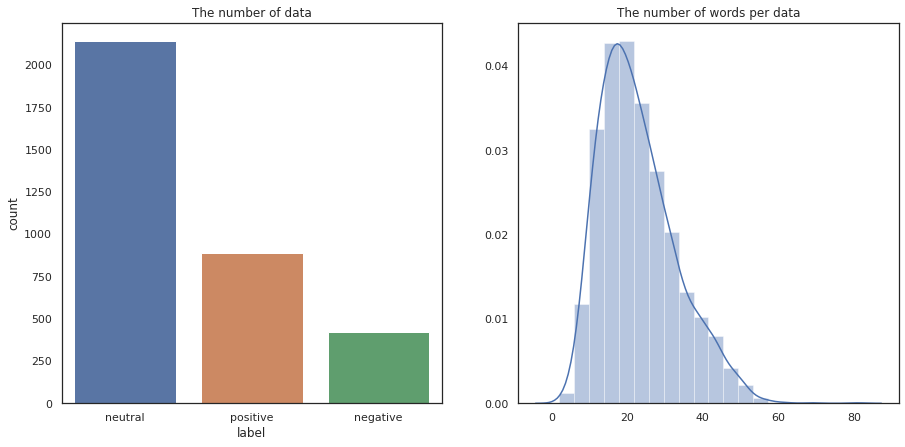

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data')
sns.distplot([len(nltk.word_tokenize(words)) for words in train_df['sentence']], bins=20, ax=ax2)
ax2.set_title('The number of words per data')

## Encode the label

In [14]:
# Encode the label
le = LabelEncoder()
le.fit(train_df['label'])
print(list(le.classes_))
train_df['label'] = le.transform(train_df['label'])
# list(le.inverse_transform(train_df['label']))
train_df['label']

['negative', 'neutral', 'positive']


0       1
1       2
2       2
3       2
4       2
       ..
3443    0
3444    0
3445    0
3446    0
3447    0
Name: label, Length: 3448, dtype: int64

The label is imbalanced and thus better to consider the measurement or balancing the data.

## Explore the text

In [15]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [16]:
corpus = create_corpus(train_df)

In [17]:
x, y = get_frequent_stop_words(corpus)

In [18]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'from', 'will')
(4257, 2311, 2086, 1792, 1706, 1169, 842, 634, 632, 557)


In [19]:
x, y = get_frequent_nonstop_words(corpus)

In [20]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', 'profit', ')', 'net', '(')
(3389, 3277, 916, 698, 574, 500, 385, 381, 378, 378)


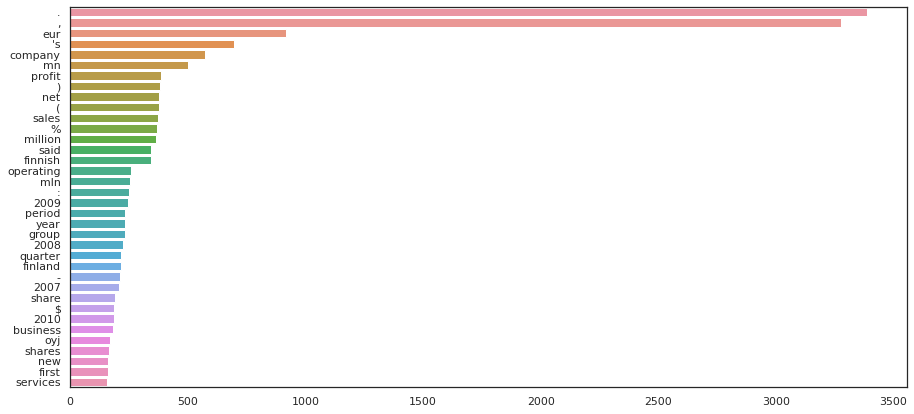

In [21]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

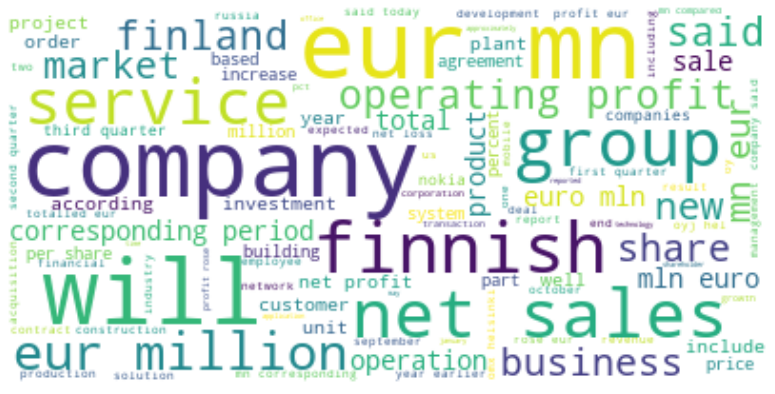

In [22]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [23]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


sentiment            word
0         Negative         ABANDON
1         Negative       ABANDONED
2         Negative      ABANDONING
3         Negative     ABANDONMENT
4         Negative    ABANDONMENTS
...            ...             ...
4135  Constraining        STRICTER
4136  Constraining       STRICTEST
4137  Constraining        STRICTLY
4138  Constraining  UNAVAILABILITY
4139  Constraining     UNAVAILABLE

[4140 rows x 2 columns]

In [24]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   184
Litigious      904
Negative      2355
Positive       354
StrongModal     19
Uncertainty    297
WeakModal       27

In [25]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [26]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [27]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df


(3448, 2)


sentence  ...                neg_words
0     According to Gran , the company has no plans t...  ...                       []
1     With the new production plant the company woul...  ...                       []
2     For the last quarter of 2010 , Componenta 's n...  ...                   [loss]
3     In the third quarter of 2010 , net sales incre...  ...                       []
4     Operating profit rose to EUR 13.1 mn from EUR ...  ...                       []
...                                                 ...  ...                      ...
3443  Operating result for the 12-month period decre...  ...                       []
3444  HELSINKI Thomson Financial - Shares in Cargote...  ...  [sharply, overshadowed]
3445  LONDON MarketWatch -- Share prices ended lower...  ...       [failed, weakness]
3446  Operating profit fell to EUR 35.4 mn from EUR ...  ...                       []
3447  Sales in Finland decreased by 10.5 % in Januar...  ...                [dropped]

[3448 rows x 8 columns]

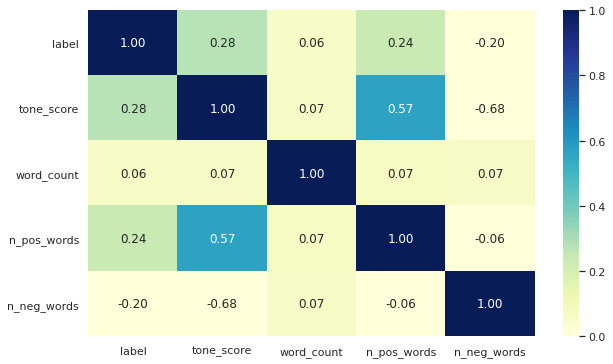

In [29]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1)
plt.show()

# Tokenize

In [30]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


## Lemmatize sentiment

In [31]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [32]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   145
Litigious      750
Negative      2355
Positive       354
StrongModal     15
Uncertainty    257

# Modeling and Training
## Common Functions

In [35]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [36]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [35]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


## A. L-M Dictionary
### Train and Test Data

In [36]:
train_tone_df.columns

Index(['sentence', 'label', 'tone_score', 'word_count', 'n_pos_words',
       'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [37]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

Fitting 7 folds for each of 480 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  2.3min finished
[2020-07-08 17:48:19,162][INFO] ## Training - acc: 0.67766497, f1: 0.52036457
[2020-07-08 17:48:19,168][INFO] ## Test - acc: 0.65942029, f1: 0.47742129


Best Score:  0.4809683350155889
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}


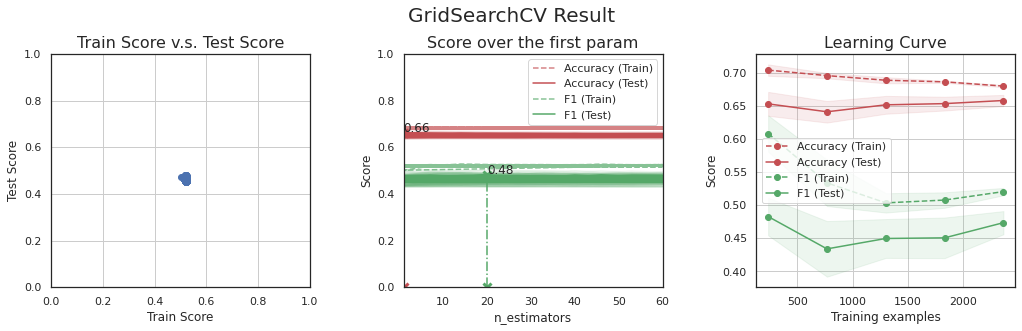

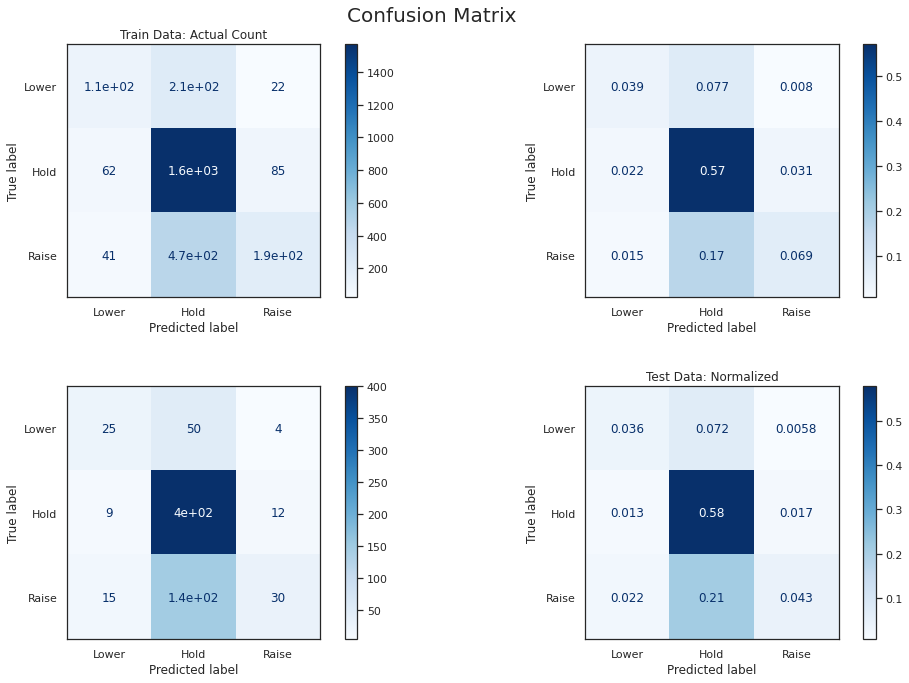

In [38]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

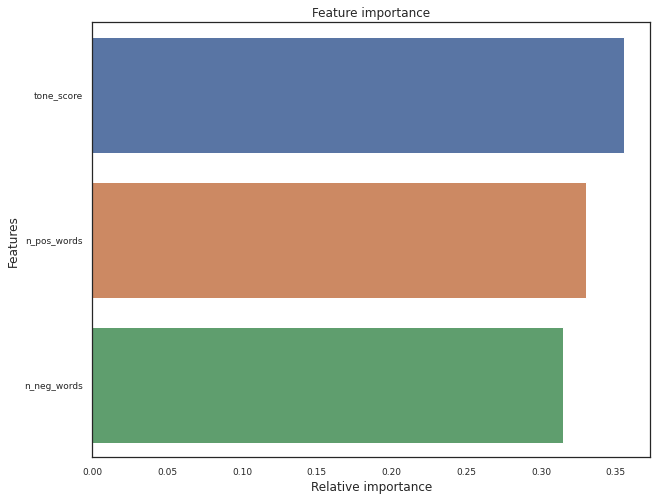

In [39]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [40]:
train_tone_df

sentence  ...                neg_words
0     According to Gran , the company has no plans t...  ...                       []
1     With the new production plant the company woul...  ...                       []
2     For the last quarter of 2010 , Componenta 's n...  ...                   [loss]
3     In the third quarter of 2010 , net sales incre...  ...                       []
4     Operating profit rose to EUR 13.1 mn from EUR ...  ...                       []
...                                                 ...  ...                      ...
3443  Operating result for the 12-month period decre...  ...                       []
3444  HELSINKI Thomson Financial - Shares in Cargote...  ...  [sharply, overshadowed]
3445  LONDON MarketWatch -- Share prices ended lower...  ...       [failed, weakness]
3446  Operating profit fell to EUR 35.4 mn from EUR ...  ...                       []
3447  Sales in Finland decreased by 10.5 % in Januar...  ...                [dropped]

[3448 rows x 8 columns]

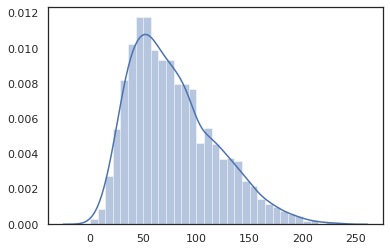

In [41]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [43]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

In [44]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-08 18:32:05,083][INFO] ## Training - acc: 0.87962292, f1: 0.82411388
[2020-07-08 18:32:05,086][INFO] ## Test - acc: 0.79420290, f1: 0.68475301


In [45]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-08 18:32:08,444][INFO] ## Training - acc: 0.99746193, f1: 0.99514652
[2020-07-08 18:32:08,449][INFO] ## Test - acc: 0.82753623, f1: 0.73160261


Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.8min finished


Best Score:  0.7066737785746835
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}


[2020-07-08 18:34:02,004][INFO] ## Training - acc: 0.99564902, f1: 0.99307637
[2020-07-08 18:34:02,008][INFO] ## Test - acc: 0.83333333, f1: 0.74792184


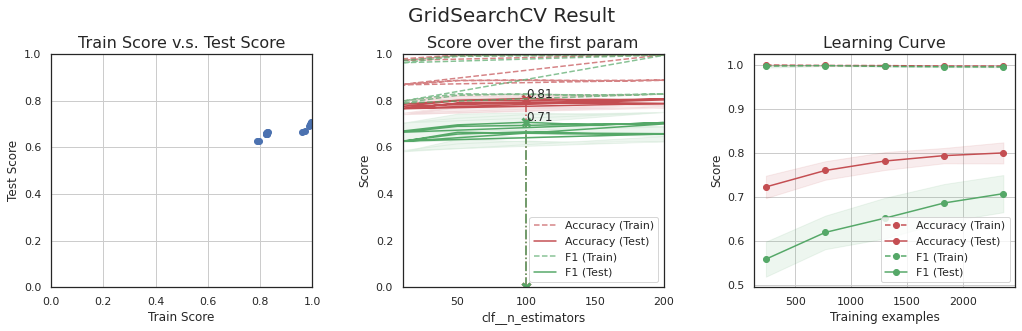

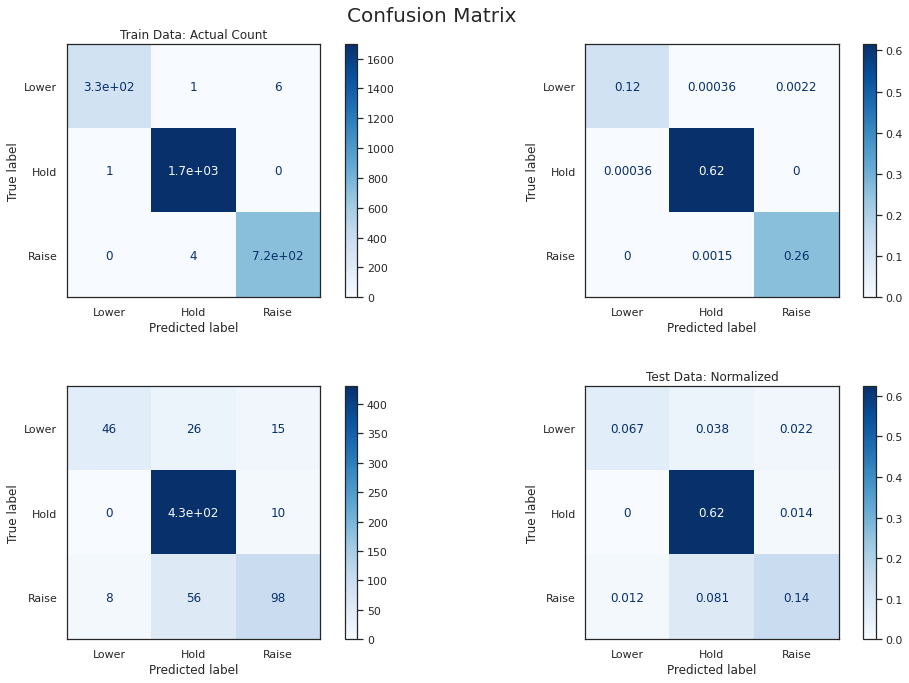

In [46]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

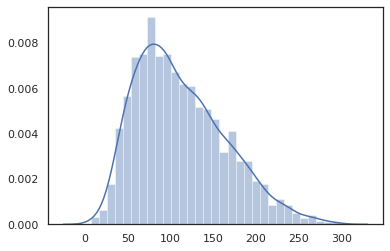

In [49]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [50]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Model
#### Embed -> RNN -> Dense -> Softmax

In [51]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [52]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [53]:
# Test
text_batch, labels = next(iter(dataloader(X_train, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

tensor([[-1.1013, -1.0108, -1.1919],
        [-1.2934, -0.9075, -1.1329],
        [-1.3891, -0.7812, -1.2281],
        [-1.2015, -0.9186, -1.2033],
        [-1.3308, -0.7909, -1.2648],
        [-1.3524, -0.8871, -1.1101],
        [-1.3759, -0.8816, -1.0988],
        [-1.1973, -0.9871, -1.1229],
        [-1.3063, -0.8480, -1.2009],
        [-1.3627, -0.7985, -1.2241],
        [-1.3533, -0.8941, -1.1008],
        [-1.3341, -0.7366, -1.3553],
        [-1.3306, -0.7754, -1.2903],
        [-1.4212, -0.7573, -1.2392],
        [-1.2849, -0.7852, -1.3193],
        [-1.3634, -0.8123, -1.2027]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Configure the model and train!

In [54]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(7136, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

In [55]:
def train_model(model, epochs=30, batch_size=32, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, labels in dataloader(
                        X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Negative', 'Neutral', 'Positive']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 1.081463... Val Loss: 1.058321 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 20... Loss: 1.009306... Val Loss: 1.048847 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 30... Loss: 1.093583... Val Loss: 1.038808 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 40... Loss: 0.974935... Val Loss: 1.027155 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 50... Loss: 1.050215... Val Loss: 1.012219 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 60... Loss: 0.916639... Val Loss: 0.992062 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 70... Loss: 1.051379... Val Loss: 0.959963 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 80... Loss: 0.936625... Val Loss: 0.916648 Accuracy: 0.626488 F1 Score: 0.256786
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.62648810, Average f1: 0.25678561



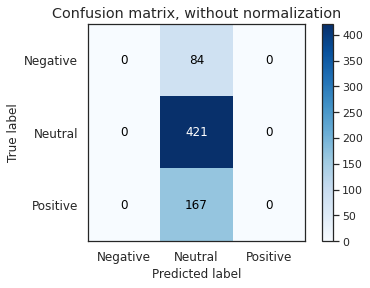

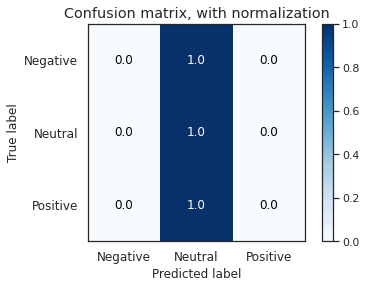

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.927149... Val Loss: 0.881567 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 20... Loss: 0.766738... Val Loss: 0.864565 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 30... Loss: 0.914497... Val Loss: 0.844990 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 40... Loss: 1.035584... Val Loss: 0.828384 Accuracy: 0.627976 F1 Score: 0.264864
Epoch: 2/30... Step: 50... Loss: 0.924643... Val Loss: 0.814725 Accuracy: 0.633929 F1 Score: 0.295240
Epoch: 2/30... Step: 60... Loss: 0.637366... Val Loss: 0.804540 Accuracy: 0.651786 F1 Score: 0.364727
Epoch: 2/30... Step: 70... Loss: 0.864632... Val Loss: 0.792508 Accuracy: 0.657738 F1 Score: 0.381485
Epoch: 2/30... Step: 80... Loss: 0.738543... Val Loss: 0.782040 Accuracy: 0.665179 F1 Score: 0.407171
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.66517857, Average f1: 0.40717087



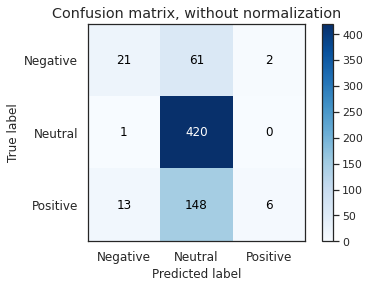

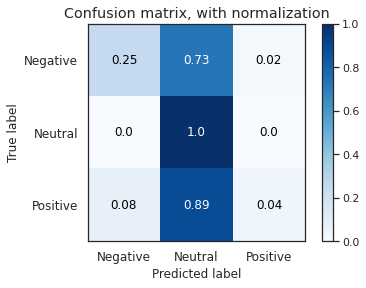

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.717574... Val Loss: 0.775208 Accuracy: 0.694940 F1 Score: 0.482499
Epoch: 3/30... Step: 20... Loss: 0.561936... Val Loss: 0.776419 Accuracy: 0.681548 F1 Score: 0.434932
Epoch: 3/30... Step: 30... Loss: 0.824509... Val Loss: 0.755823 Accuracy: 0.691964 F1 Score: 0.432948
Epoch: 3/30... Step: 40... Loss: 0.894943... Val Loss: 0.751976 Accuracy: 0.691964 F1 Score: 0.430460
Epoch: 3/30... Step: 50... Loss: 0.809315... Val Loss: 0.747182 Accuracy: 0.691964 F1 Score: 0.424158
Epoch: 3/30... Step: 60... Loss: 0.558645... Val Loss: 0.748530 Accuracy: 0.684524 F1 Score: 0.425847
Epoch: 3/30... Step: 70... Loss: 0.748182... Val Loss: 0.731127 Accuracy: 0.690476 F1 Score: 0.425036
Epoch: 3/30... Step: 80... Loss: 0.633510... Val Loss: 0.726966 Accuracy: 0.691964 F1 Score: 0.426464
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.69196429, Average f1: 0.42646408



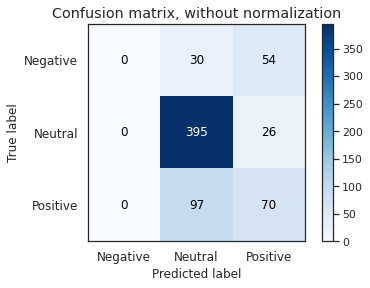

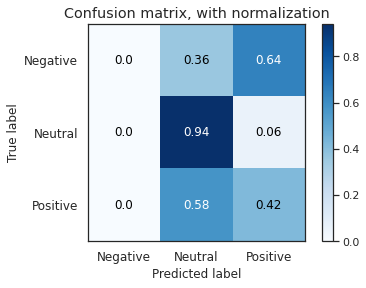

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.608853... Val Loss: 0.736711 Accuracy: 0.674107 F1 Score: 0.437692
Epoch: 4/30... Step: 20... Loss: 0.515912... Val Loss: 0.728527 Accuracy: 0.691964 F1 Score: 0.432219
Epoch: 4/30... Step: 30... Loss: 0.717500... Val Loss: 0.714345 Accuracy: 0.683036 F1 Score: 0.436875
Epoch: 4/30... Step: 40... Loss: 0.819181... Val Loss: 0.706044 Accuracy: 0.690476 F1 Score: 0.444041
Epoch: 4/30... Step: 50... Loss: 0.749355... Val Loss: 0.700244 Accuracy: 0.694940 F1 Score: 0.445799
Epoch: 4/30... Step: 60... Loss: 0.489118... Val Loss: 0.707056 Accuracy: 0.680060 F1 Score: 0.450085
Epoch: 4/30... Step: 70... Loss: 0.679388... Val Loss: 0.682974 Accuracy: 0.699405 F1 Score: 0.460190
Epoch: 4/30... Step: 80... Loss: 0.538199... Val Loss: 0.682055 Accuracy: 0.699405 F1 Score: 0.457320
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.69940476, Average f1: 0.45732031



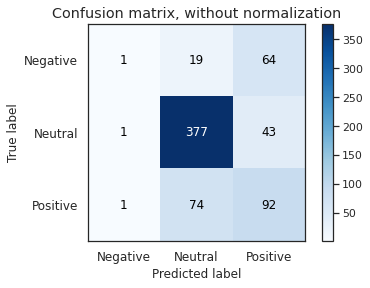

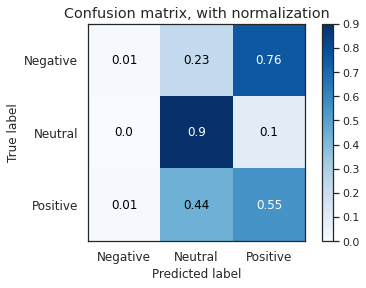

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.512109... Val Loss: 0.694449 Accuracy: 0.684524 F1 Score: 0.480758
Epoch: 5/30... Step: 20... Loss: 0.443297... Val Loss: 0.676488 Accuracy: 0.708333 F1 Score: 0.469126
Epoch: 5/30... Step: 30... Loss: 0.635690... Val Loss: 0.666153 Accuracy: 0.705357 F1 Score: 0.499546
Epoch: 5/30... Step: 40... Loss: 0.652534... Val Loss: 0.659527 Accuracy: 0.706845 F1 Score: 0.518437
Epoch: 5/30... Step: 50... Loss: 0.682202... Val Loss: 0.655101 Accuracy: 0.727679 F1 Score: 0.548664
Epoch: 5/30... Step: 60... Loss: 0.435786... Val Loss: 0.661707 Accuracy: 0.708333 F1 Score: 0.563080
Epoch: 5/30... Step: 70... Loss: 0.629838... Val Loss: 0.647660 Accuracy: 0.727679 F1 Score: 0.561848
Epoch: 5/30... Step: 80... Loss: 0.423907... Val Loss: 0.678509 Accuracy: 0.696429 F1 Score: 0.558964
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.69642857, Average f1: 0.55896402



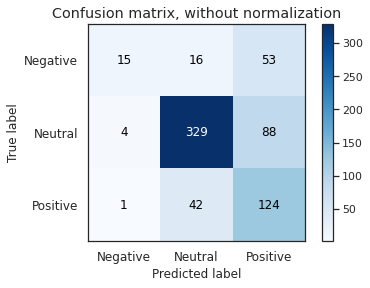

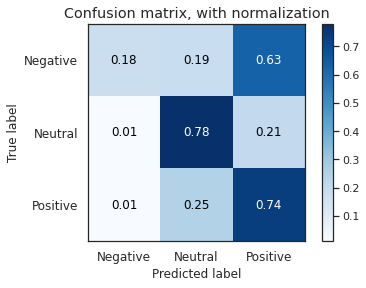

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.436234... Val Loss: 0.689860 Accuracy: 0.693452 F1 Score: 0.575178
Epoch: 6/30... Step: 20... Loss: 0.376931... Val Loss: 0.647627 Accuracy: 0.744048 F1 Score: 0.591767
Epoch: 6/30... Step: 30... Loss: 0.484133... Val Loss: 0.629745 Accuracy: 0.741071 F1 Score: 0.600989
Epoch: 6/30... Step: 40... Loss: 0.558034... Val Loss: 0.632457 Accuracy: 0.718750 F1 Score: 0.597143
Epoch: 6/30... Step: 50... Loss: 0.624386... Val Loss: 0.620815 Accuracy: 0.745536 F1 Score: 0.604832
Epoch: 6/30... Step: 60... Loss: 0.288543... Val Loss: 0.623973 Accuracy: 0.732143 F1 Score: 0.627418
Epoch: 6/30... Step: 70... Loss: 0.528826... Val Loss: 0.618913 Accuracy: 0.754464 F1 Score: 0.629855
Epoch: 6/30... Step: 80... Loss: 0.313768... Val Loss: 0.655792 Accuracy: 0.721726 F1 Score: 0.624456
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.72172619, Average f1: 0.62445630



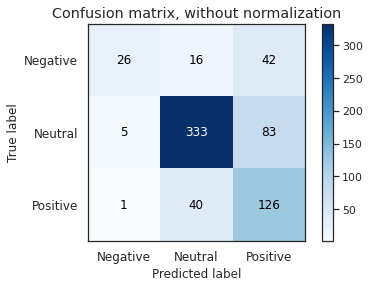

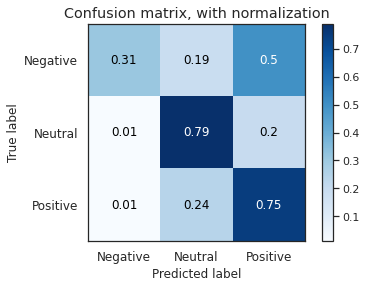

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.340169... Val Loss: 0.665213 Accuracy: 0.715774 F1 Score: 0.626100
Epoch: 7/30... Step: 20... Loss: 0.342982... Val Loss: 0.617574 Accuracy: 0.769345 F1 Score: 0.644941
Epoch: 7/30... Step: 30... Loss: 0.452934... Val Loss: 0.614676 Accuracy: 0.770833 F1 Score: 0.647778
Epoch: 7/30... Step: 40... Loss: 0.561442... Val Loss: 0.649681 Accuracy: 0.717262 F1 Score: 0.632936
Epoch: 7/30... Step: 50... Loss: 0.521853... Val Loss: 0.600402 Accuracy: 0.772321 F1 Score: 0.653905
Epoch: 7/30... Step: 60... Loss: 0.187740... Val Loss: 0.591634 Accuracy: 0.744048 F1 Score: 0.643400
Epoch: 7/30... Step: 70... Loss: 0.425095... Val Loss: 0.591608 Accuracy: 0.758929 F1 Score: 0.658666
Epoch: 7/30... Step: 80... Loss: 0.337597... Val Loss: 0.612321 Accuracy: 0.767857 F1 Score: 0.648254
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.76785714, Average f1: 0.64825355



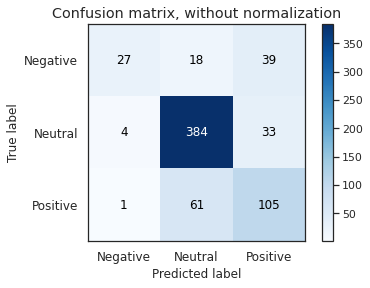

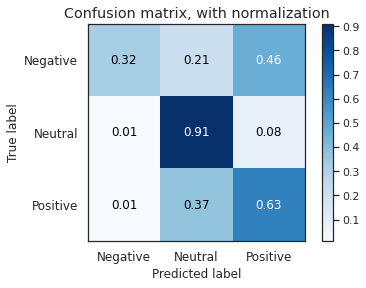

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.247266... Val Loss: 0.614561 Accuracy: 0.744048 F1 Score: 0.678970
Epoch: 8/30... Step: 20... Loss: 0.306790... Val Loss: 0.613403 Accuracy: 0.755952 F1 Score: 0.660348
Epoch: 8/30... Step: 30... Loss: 0.321513... Val Loss: 0.634413 Accuracy: 0.770833 F1 Score: 0.648635
Epoch: 8/30... Step: 40... Loss: 0.496714... Val Loss: 0.701009 Accuracy: 0.714286 F1 Score: 0.660357
Epoch: 8/30... Step: 50... Loss: 0.517870... Val Loss: 0.594871 Accuracy: 0.782738 F1 Score: 0.692500
Epoch: 8/30... Step: 60... Loss: 0.144425... Val Loss: 0.572396 Accuracy: 0.779762 F1 Score: 0.699064
Epoch: 8/30... Step: 70... Loss: 0.332322... Val Loss: 0.588662 Accuracy: 0.758929 F1 Score: 0.673982
Epoch: 8/30... Step: 80... Loss: 0.189538... Val Loss: 0.607965 Accuracy: 0.769345 F1 Score: 0.657212
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.76934524, Average f1: 0.65721185



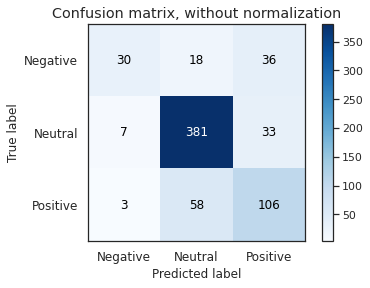

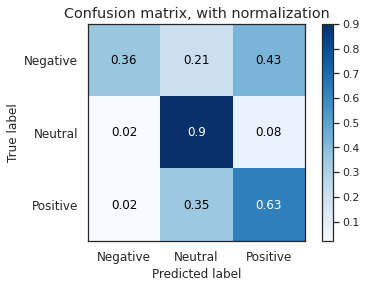

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.204311... Val Loss: 0.627937 Accuracy: 0.755952 F1 Score: 0.694703
Epoch: 9/30... Step: 20... Loss: 0.185672... Val Loss: 0.618376 Accuracy: 0.772321 F1 Score: 0.692482
Epoch: 9/30... Step: 30... Loss: 0.232197... Val Loss: 0.607861 Accuracy: 0.782738 F1 Score: 0.691826
Epoch: 9/30... Step: 40... Loss: 0.432516... Val Loss: 0.627950 Accuracy: 0.751488 F1 Score: 0.680757
Epoch: 9/30... Step: 50... Loss: 0.441719... Val Loss: 0.572562 Accuracy: 0.781250 F1 Score: 0.703734
Epoch: 9/30... Step: 60... Loss: 0.104300... Val Loss: 0.570157 Accuracy: 0.787202 F1 Score: 0.716171
Epoch: 9/30... Step: 70... Loss: 0.272027... Val Loss: 0.585564 Accuracy: 0.787202 F1 Score: 0.711609
Epoch: 9/30... Step: 80... Loss: 0.182358... Val Loss: 0.610623 Accuracy: 0.779762 F1 Score: 0.700088
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.77976190, Average f1: 0.70008837



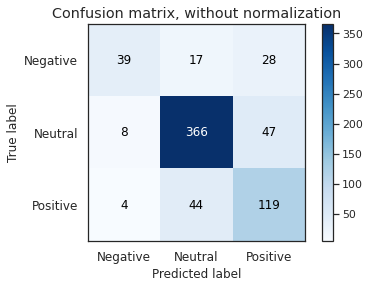

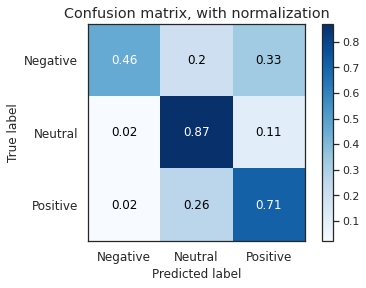

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.158577... Val Loss: 0.627807 Accuracy: 0.781250 F1 Score: 0.720939
Epoch: 10/30... Step: 20... Loss: 0.129581... Val Loss: 0.657569 Accuracy: 0.779762 F1 Score: 0.709451
Epoch: 10/30... Step: 30... Loss: 0.186224... Val Loss: 0.606350 Accuracy: 0.793155 F1 Score: 0.723960
Epoch: 10/30... Step: 40... Loss: 0.271327... Val Loss: 0.617175 Accuracy: 0.782738 F1 Score: 0.724823
Epoch: 10/30... Step: 50... Loss: 0.393410... Val Loss: 0.597788 Accuracy: 0.784226 F1 Score: 0.718248
Epoch: 10/30... Step: 60... Loss: 0.074585... Val Loss: 0.610152 Accuracy: 0.797619 F1 Score: 0.721988
Epoch: 10/30... Step: 70... Loss: 0.218381... Val Loss: 0.613447 Accuracy: 0.782738 F1 Score: 0.725284
Epoch: 10/30... Step: 80... Loss: 0.153072... Val Loss: 0.608589 Accuracy: 0.787202 F1 Score: 0.710195
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.78720238, Average f1: 0.71019536



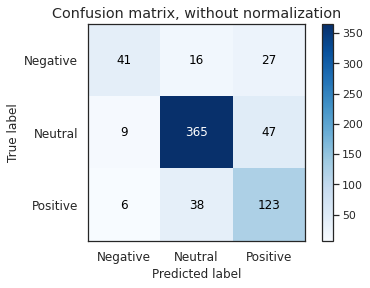

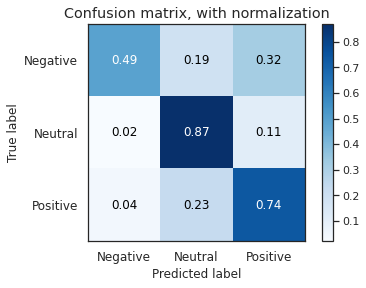

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.105845... Val Loss: 0.603034 Accuracy: 0.790179 F1 Score: 0.728540
Epoch: 11/30... Step: 20... Loss: 0.129535... Val Loss: 0.696333 Accuracy: 0.772321 F1 Score: 0.721253
Epoch: 11/30... Step: 30... Loss: 0.138858... Val Loss: 0.618172 Accuracy: 0.802083 F1 Score: 0.739696
Epoch: 11/30... Step: 40... Loss: 0.188948... Val Loss: 0.632836 Accuracy: 0.799107 F1 Score: 0.743323
Epoch: 11/30... Step: 50... Loss: 0.350235... Val Loss: 0.674972 Accuracy: 0.775298 F1 Score: 0.728617
Epoch: 11/30... Step: 60... Loss: 0.052035... Val Loss: 0.665730 Accuracy: 0.803571 F1 Score: 0.730073
Epoch: 11/30... Step: 70... Loss: 0.086303... Val Loss: 0.667009 Accuracy: 0.770833 F1 Score: 0.727009
Epoch: 11/30... Step: 80... Loss: 0.107830... Val Loss: 0.623247 Accuracy: 0.799107 F1 Score: 0.740073
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.79910714, Average f1: 0.74007313



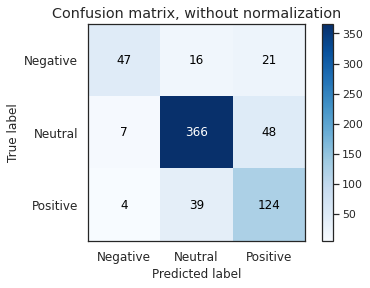

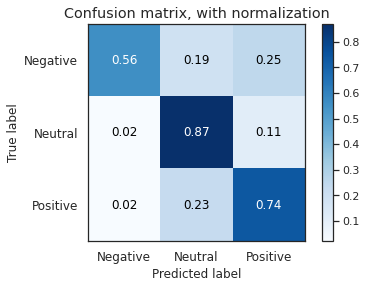

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.088142... Val Loss: 0.602357 Accuracy: 0.806548 F1 Score: 0.753738
Epoch: 12/30... Step: 20... Loss: 0.098561... Val Loss: 0.675568 Accuracy: 0.787202 F1 Score: 0.747259
Epoch: 12/30... Step: 30... Loss: 0.107314... Val Loss: 0.669605 Accuracy: 0.797619 F1 Score: 0.730979
Epoch: 12/30... Step: 40... Loss: 0.147963... Val Loss: 0.638533 Accuracy: 0.815476 F1 Score: 0.773265
Epoch: 12/30... Step: 50... Loss: 0.340085... Val Loss: 0.686138 Accuracy: 0.772321 F1 Score: 0.728845
Epoch: 12/30... Step: 60... Loss: 0.035900... Val Loss: 0.660950 Accuracy: 0.809524 F1 Score: 0.754320
Epoch: 12/30... Step: 70... Loss: 0.103956... Val Loss: 0.648088 Accuracy: 0.793155 F1 Score: 0.748301
Epoch: 12/30... Step: 80... Loss: 0.081354... Val Loss: 0.674252 Accuracy: 0.787202 F1 Score: 0.737844
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.78720238, Average f1: 0.73784416



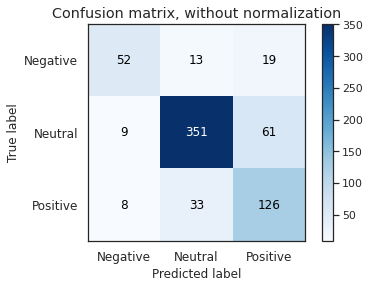

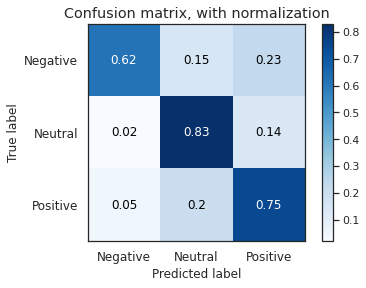

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.068646... Val Loss: 0.611901 Accuracy: 0.800595 F1 Score: 0.751556
Epoch: 13/30... Step: 20... Loss: 0.074604... Val Loss: 0.640494 Accuracy: 0.802083 F1 Score: 0.756986
Epoch: 13/30... Step: 30... Loss: 0.084149... Val Loss: 0.689019 Accuracy: 0.805060 F1 Score: 0.753900
Epoch: 13/30... Step: 40... Loss: 0.115042... Val Loss: 0.694906 Accuracy: 0.808036 F1 Score: 0.757682
Epoch: 13/30... Step: 50... Loss: 0.280343... Val Loss: 0.815994 Accuracy: 0.742560 F1 Score: 0.702549
Epoch: 13/30... Step: 60... Loss: 0.032217... Val Loss: 0.652825 Accuracy: 0.809524 F1 Score: 0.751779
Epoch: 13/30... Step: 70... Loss: 0.122989... Val Loss: 0.656521 Accuracy: 0.815476 F1 Score: 0.760267
Epoch: 13/30... Step: 80... Loss: 0.069522... Val Loss: 0.943875 Accuracy: 0.706845 F1 Score: 0.688632
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.70684524, Average f1: 0.68863224



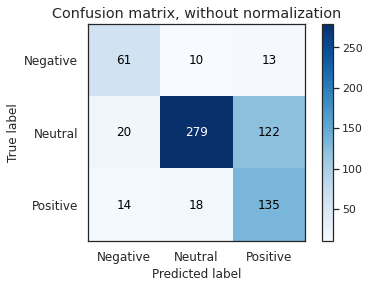

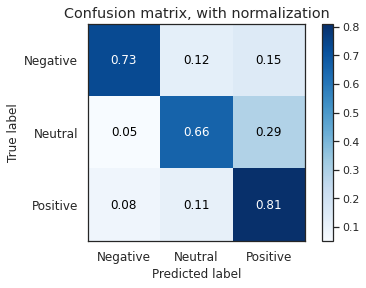

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.050924... Val Loss: 0.640512 Accuracy: 0.815476 F1 Score: 0.762381
Epoch: 14/30... Step: 20... Loss: 0.111187... Val Loss: 0.664302 Accuracy: 0.788690 F1 Score: 0.737763
Epoch: 14/30... Step: 30... Loss: 0.079699... Val Loss: 0.710501 Accuracy: 0.800595 F1 Score: 0.742517
Epoch: 14/30... Step: 40... Loss: 0.096061... Val Loss: 0.705663 Accuracy: 0.791667 F1 Score: 0.725401
Epoch: 14/30... Step: 50... Loss: 0.161789... Val Loss: 0.691568 Accuracy: 0.787202 F1 Score: 0.732261
Epoch: 14/30... Step: 60... Loss: 0.039828... Val Loss: 0.676016 Accuracy: 0.799107 F1 Score: 0.752956
Epoch: 14/30... Step: 70... Loss: 0.076379... Val Loss: 0.736024 Accuracy: 0.812500 F1 Score: 0.749435
Epoch: 14/30... Step: 80... Loss: 0.026559... Val Loss: 0.694628 Accuracy: 0.791667 F1 Score: 0.745332
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.79166667, Average f1: 0.74533160



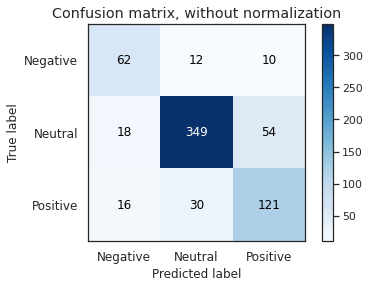

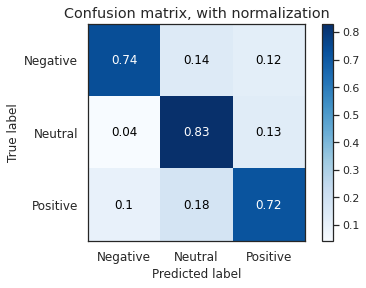

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.042301... Val Loss: 0.674531 Accuracy: 0.815476 F1 Score: 0.759990
Epoch: 15/30... Step: 20... Loss: 0.042622... Val Loss: 0.637059 Accuracy: 0.816964 F1 Score: 0.772134
Epoch: 15/30... Step: 30... Loss: 0.078735... Val Loss: 0.740675 Accuracy: 0.775298 F1 Score: 0.740459
Epoch: 15/30... Step: 40... Loss: 0.086324... Val Loss: 0.689440 Accuracy: 0.811012 F1 Score: 0.753221
Epoch: 15/30... Step: 50... Loss: 0.187029... Val Loss: 0.706782 Accuracy: 0.811012 F1 Score: 0.774965
Epoch: 15/30... Step: 60... Loss: 0.106556... Val Loss: 0.735919 Accuracy: 0.769345 F1 Score: 0.715074
Epoch: 15/30... Step: 70... Loss: 0.058770... Val Loss: 0.743643 Accuracy: 0.811012 F1 Score: 0.736169
Epoch: 15/30... Step: 80... Loss: 0.029428... Val Loss: 0.700919 Accuracy: 0.813988 F1 Score: 0.767022
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.81398810, Average f1: 0.76702205



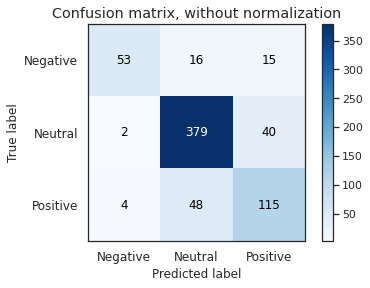

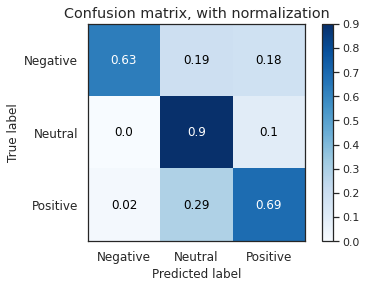

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.039378... Val Loss: 0.691816 Accuracy: 0.811012 F1 Score: 0.769883
Epoch: 16/30... Step: 20... Loss: 0.015090... Val Loss: 0.705681 Accuracy: 0.812500 F1 Score: 0.769121
Epoch: 16/30... Step: 30... Loss: 0.077942... Val Loss: 0.679313 Accuracy: 0.802083 F1 Score: 0.751231
Epoch: 16/30... Step: 40... Loss: 0.067590... Val Loss: 0.686560 Accuracy: 0.821429 F1 Score: 0.779657
Epoch: 16/30... Step: 50... Loss: 0.128008... Val Loss: 0.718231 Accuracy: 0.816964 F1 Score: 0.771738
Epoch: 16/30... Step: 60... Loss: 0.035483... Val Loss: 0.701309 Accuracy: 0.784226 F1 Score: 0.738837
Epoch: 16/30... Step: 70... Loss: 0.044036... Val Loss: 0.671490 Accuracy: 0.819940 F1 Score: 0.777881
Epoch: 16/30... Step: 80... Loss: 0.022529... Val Loss: 0.724204 Accuracy: 0.824405 F1 Score: 0.771899
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.82440476, Average f1: 0.77189919



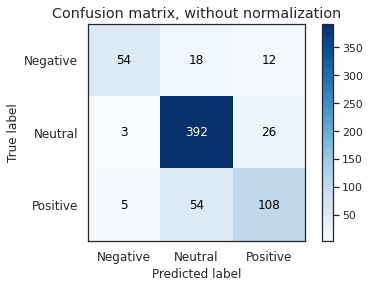

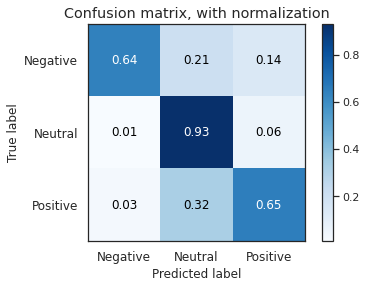

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.028919... Val Loss: 0.697190 Accuracy: 0.813988 F1 Score: 0.775282
Epoch: 17/30... Step: 20... Loss: 0.155040... Val Loss: 0.694086 Accuracy: 0.821429 F1 Score: 0.781701
Epoch: 17/30... Step: 30... Loss: 0.033602... Val Loss: 0.735292 Accuracy: 0.816964 F1 Score: 0.773942
Epoch: 17/30... Step: 40... Loss: 0.060216... Val Loss: 0.748857 Accuracy: 0.808036 F1 Score: 0.772961
Epoch: 17/30... Step: 50... Loss: 0.065410... Val Loss: 0.721788 Accuracy: 0.825893 F1 Score: 0.787631
Epoch: 17/30... Step: 60... Loss: 0.015959... Val Loss: 0.724940 Accuracy: 0.809524 F1 Score: 0.766489
Epoch: 17/30... Step: 70... Loss: 0.036211... Val Loss: 0.712344 Accuracy: 0.811012 F1 Score: 0.767945
Epoch: 17/30... Step: 80... Loss: 0.009887... Val Loss: 0.719104 Accuracy: 0.825893 F1 Score: 0.787223
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.82589286, Average f1: 0.78722347



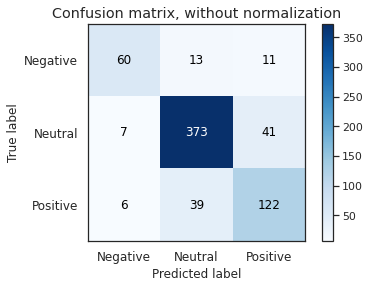

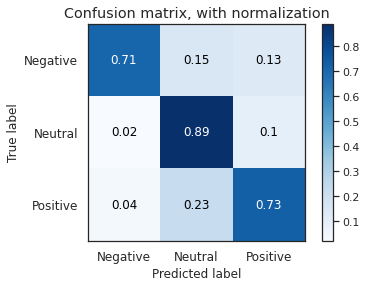

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.034196... Val Loss: 0.721868 Accuracy: 0.824405 F1 Score: 0.780411
Epoch: 18/30... Step: 20... Loss: 0.078013... Val Loss: 0.724005 Accuracy: 0.821429 F1 Score: 0.778369
Epoch: 18/30... Step: 30... Loss: 0.019455... Val Loss: 0.741699 Accuracy: 0.828869 F1 Score: 0.786656
Epoch: 18/30... Step: 40... Loss: 0.047850... Val Loss: 0.774807 Accuracy: 0.813988 F1 Score: 0.777030
Epoch: 18/30... Step: 50... Loss: 0.047350... Val Loss: 0.789101 Accuracy: 0.815476 F1 Score: 0.781235
Epoch: 18/30... Step: 60... Loss: 0.012329... Val Loss: 0.788354 Accuracy: 0.802083 F1 Score: 0.763247
Epoch: 18/30... Step: 70... Loss: 0.029969... Val Loss: 0.746810 Accuracy: 0.828869 F1 Score: 0.787949
Epoch: 18/30... Step: 80... Loss: 0.008166... Val Loss: 0.736582 Accuracy: 0.825893 F1 Score: 0.781055
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.82589286, Average f1: 0.78105464



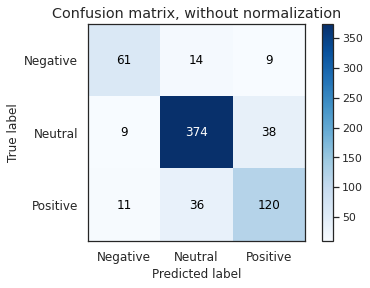

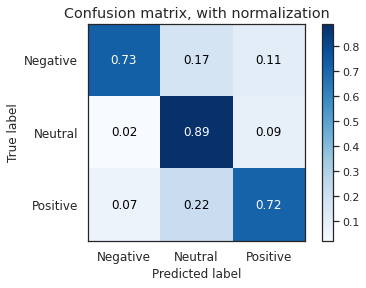

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.006857... Val Loss: 0.751237 Accuracy: 0.818452 F1 Score: 0.771650
Epoch: 19/30... Step: 20... Loss: 0.013339... Val Loss: 0.757979 Accuracy: 0.822917 F1 Score: 0.781493
Epoch: 19/30... Step: 30... Loss: 0.013541... Val Loss: 0.766256 Accuracy: 0.824405 F1 Score: 0.783387
Epoch: 19/30... Step: 40... Loss: 0.041478... Val Loss: 0.798076 Accuracy: 0.824405 F1 Score: 0.782333
Epoch: 19/30... Step: 50... Loss: 0.039596... Val Loss: 0.828974 Accuracy: 0.808036 F1 Score: 0.768742
Epoch: 19/30... Step: 60... Loss: 0.013116... Val Loss: 0.850498 Accuracy: 0.781250 F1 Score: 0.731275
Epoch: 19/30... Step: 70... Loss: 0.029502... Val Loss: 0.763272 Accuracy: 0.828869 F1 Score: 0.782253
Epoch: 19/30... Step: 80... Loss: 0.006674... Val Loss: 0.796909 Accuracy: 0.825893 F1 Score: 0.781596
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.82589286, Average f1: 0.78159606



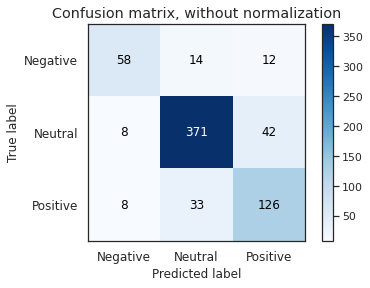

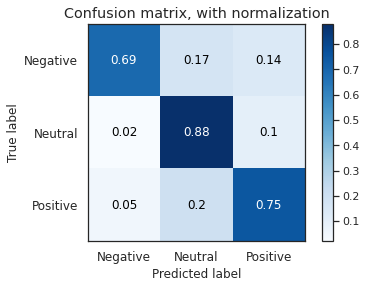

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.010531... Val Loss: 0.817414 Accuracy: 0.824405 F1 Score: 0.778182
Epoch: 20/30... Step: 20... Loss: 0.025184... Val Loss: 0.811865 Accuracy: 0.818452 F1 Score: 0.772735
Epoch: 20/30... Step: 30... Loss: 0.010761... Val Loss: 0.817459 Accuracy: 0.828869 F1 Score: 0.787655
Epoch: 20/30... Step: 40... Loss: 0.035164... Val Loss: 0.846768 Accuracy: 0.818452 F1 Score: 0.778246
Epoch: 20/30... Step: 50... Loss: 0.027525... Val Loss: 0.878788 Accuracy: 0.809524 F1 Score: 0.767305
Epoch: 20/30... Step: 60... Loss: 0.006809... Val Loss: 0.876673 Accuracy: 0.808036 F1 Score: 0.767749
Epoch: 20/30... Step: 70... Loss: 0.015108... Val Loss: 0.788311 Accuracy: 0.824405 F1 Score: 0.778460
Epoch: 20/30... Step: 80... Loss: 0.005662... Val Loss: 0.836415 Accuracy: 0.825893 F1 Score: 0.778344
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.82589286, Average f1: 0.77834427



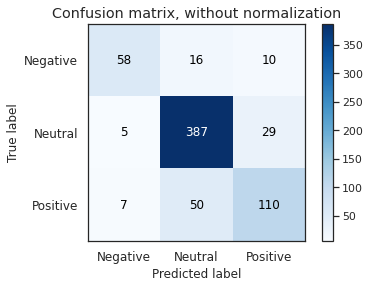

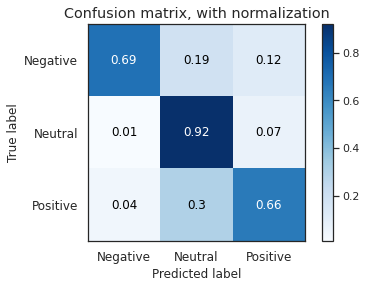

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.007021... Val Loss: 0.822534 Accuracy: 0.812500 F1 Score: 0.770056
Epoch: 21/30... Step: 20... Loss: 0.006814... Val Loss: 0.823592 Accuracy: 0.821429 F1 Score: 0.779341
Epoch: 21/30... Step: 30... Loss: 0.007036... Val Loss: 0.821622 Accuracy: 0.816964 F1 Score: 0.779523
Epoch: 21/30... Step: 40... Loss: 0.030909... Val Loss: 0.831386 Accuracy: 0.824405 F1 Score: 0.782079
Epoch: 21/30... Step: 50... Loss: 0.018306... Val Loss: 0.859564 Accuracy: 0.819940 F1 Score: 0.769629
Epoch: 21/30... Step: 60... Loss: 0.007969... Val Loss: 0.871410 Accuracy: 0.808036 F1 Score: 0.767934
Epoch: 21/30... Step: 70... Loss: 0.030872... Val Loss: 0.858070 Accuracy: 0.811012 F1 Score: 0.769097
Epoch: 21/30... Step: 80... Loss: 0.004077... Val Loss: 0.841021 Accuracy: 0.821429 F1 Score: 0.775303
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.82142857, Average f1: 0.77530334



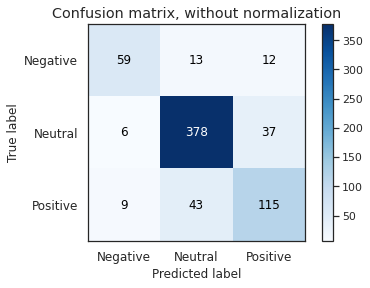

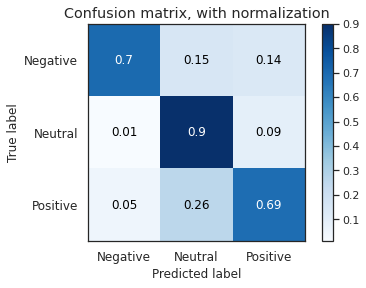

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.006186... Val Loss: 0.853058 Accuracy: 0.821429 F1 Score: 0.774619
Epoch: 22/30... Step: 20... Loss: 0.116164... Val Loss: 0.866078 Accuracy: 0.815476 F1 Score: 0.769533
Epoch: 22/30... Step: 30... Loss: 0.006933... Val Loss: 0.885685 Accuracy: 0.822917 F1 Score: 0.779573
Epoch: 22/30... Step: 40... Loss: 0.030110... Val Loss: 0.872549 Accuracy: 0.827381 F1 Score: 0.780349
Epoch: 22/30... Step: 50... Loss: 0.014633... Val Loss: 0.864566 Accuracy: 0.825893 F1 Score: 0.779694
Epoch: 22/30... Step: 60... Loss: 0.006358... Val Loss: 0.871965 Accuracy: 0.808036 F1 Score: 0.760140
Epoch: 22/30... Step: 70... Loss: 0.015427... Val Loss: 0.881560 Accuracy: 0.808036 F1 Score: 0.760645
Epoch: 22/30... Step: 80... Loss: 0.003965... Val Loss: 0.879239 Accuracy: 0.825893 F1 Score: 0.784227
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.82589286, Average f1: 0.78422659



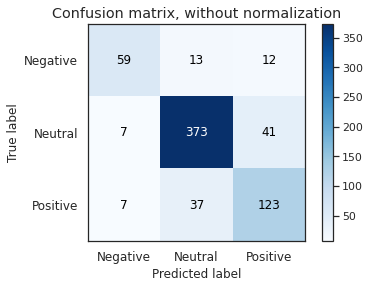

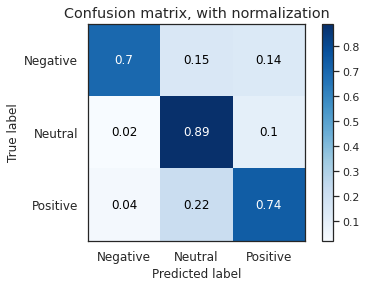

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.006654... Val Loss: 0.871341 Accuracy: 0.824405 F1 Score: 0.778740
Epoch: 23/30... Step: 20... Loss: 0.010080... Val Loss: 0.869954 Accuracy: 0.812500 F1 Score: 0.763568
Epoch: 23/30... Step: 30... Loss: 0.006717... Val Loss: 0.865923 Accuracy: 0.818452 F1 Score: 0.773009
Epoch: 23/30... Step: 40... Loss: 0.022805... Val Loss: 0.868835 Accuracy: 0.821429 F1 Score: 0.778435
Epoch: 23/30... Step: 50... Loss: 0.008792... Val Loss: 0.888453 Accuracy: 0.828869 F1 Score: 0.785555
Epoch: 23/30... Step: 60... Loss: 0.006054... Val Loss: 0.889551 Accuracy: 0.813988 F1 Score: 0.764605
Epoch: 23/30... Step: 70... Loss: 0.009021... Val Loss: 0.890478 Accuracy: 0.813988 F1 Score: 0.769281
Epoch: 23/30... Step: 80... Loss: 0.004573... Val Loss: 0.896794 Accuracy: 0.816964 F1 Score: 0.767601
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.81696429, Average f1: 0.76760129



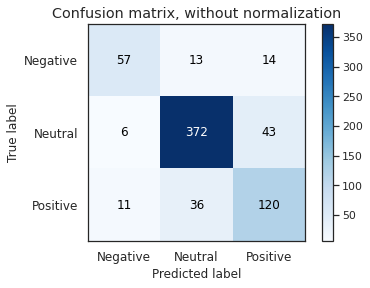

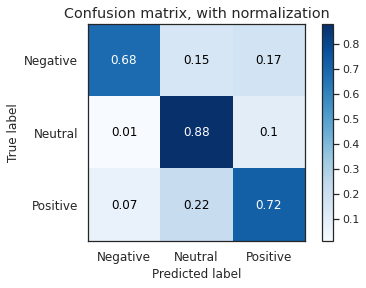

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.004971... Val Loss: 0.915832 Accuracy: 0.815476 F1 Score: 0.766389
Epoch: 24/30... Step: 20... Loss: 0.007603... Val Loss: 0.907641 Accuracy: 0.818452 F1 Score: 0.773014
Epoch: 24/30... Step: 30... Loss: 0.006100... Val Loss: 0.881076 Accuracy: 0.812500 F1 Score: 0.763568
Epoch: 24/30... Step: 40... Loss: 0.018844... Val Loss: 0.874620 Accuracy: 0.815476 F1 Score: 0.767539
Epoch: 24/30... Step: 50... Loss: 0.015639... Val Loss: 0.903401 Accuracy: 0.827381 F1 Score: 0.776439
Epoch: 24/30... Step: 60... Loss: 0.004123... Val Loss: 0.883294 Accuracy: 0.816964 F1 Score: 0.769948
Epoch: 24/30... Step: 70... Loss: 0.009872... Val Loss: 0.900303 Accuracy: 0.805060 F1 Score: 0.760785
Epoch: 24/30... Step: 80... Loss: 0.004389... Val Loss: 0.900597 Accuracy: 0.816964 F1 Score: 0.772694
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.81696429, Average f1: 0.77269434



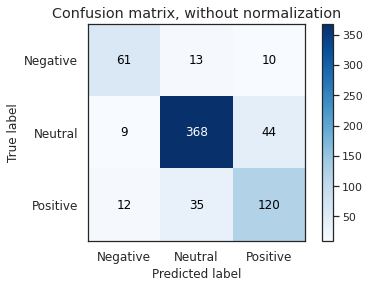

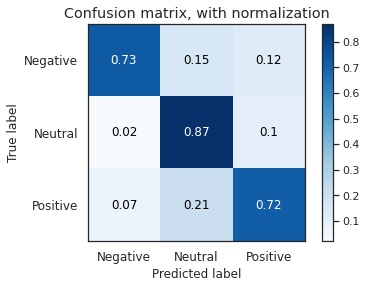

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.006217... Val Loss: 0.908258 Accuracy: 0.816964 F1 Score: 0.768118
Epoch: 25/30... Step: 20... Loss: 0.016964... Val Loss: 0.986480 Accuracy: 0.794643 F1 Score: 0.746617
Epoch: 25/30... Step: 30... Loss: 0.006654... Val Loss: 0.989474 Accuracy: 0.791667 F1 Score: 0.746216
Epoch: 25/30... Step: 40... Loss: 0.013523... Val Loss: 0.987798 Accuracy: 0.797619 F1 Score: 0.754814
Epoch: 25/30... Step: 50... Loss: 0.014140... Val Loss: 0.953928 Accuracy: 0.808036 F1 Score: 0.767779
Epoch: 25/30... Step: 60... Loss: 0.006012... Val Loss: 1.018851 Accuracy: 0.806548 F1 Score: 0.757197
Epoch: 25/30... Step: 70... Loss: 0.008359... Val Loss: 0.972489 Accuracy: 0.797619 F1 Score: 0.754646
Epoch: 25/30... Step: 80... Loss: 0.004876... Val Loss: 0.922491 Accuracy: 0.809524 F1 Score: 0.769121
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.80952381, Average f1: 0.76912071



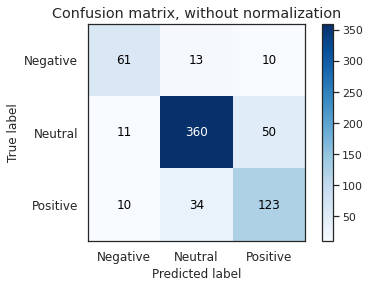

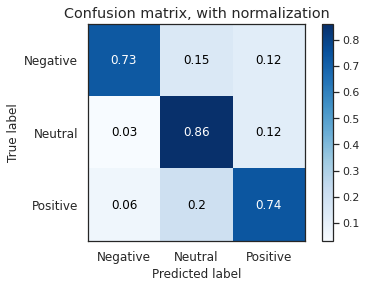

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.003058... Val Loss: 0.907678 Accuracy: 0.821429 F1 Score: 0.778171
Epoch: 26/30... Step: 20... Loss: 0.006037... Val Loss: 1.020555 Accuracy: 0.794643 F1 Score: 0.759555
Epoch: 26/30... Step: 30... Loss: 0.014904... Val Loss: 0.989639 Accuracy: 0.799107 F1 Score: 0.763466
Epoch: 26/30... Step: 40... Loss: 0.014251... Val Loss: 0.927949 Accuracy: 0.818452 F1 Score: 0.782225
Epoch: 26/30... Step: 50... Loss: 0.008587... Val Loss: 0.923058 Accuracy: 0.825893 F1 Score: 0.789603
Epoch: 26/30... Step: 60... Loss: 0.004275... Val Loss: 0.914733 Accuracy: 0.809524 F1 Score: 0.763938
Epoch: 26/30... Step: 70... Loss: 0.007326... Val Loss: 0.919596 Accuracy: 0.811012 F1 Score: 0.764248
Epoch: 26/30... Step: 80... Loss: 0.002675... Val Loss: 0.921008 Accuracy: 0.812500 F1 Score: 0.765370
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.81250000, Average f1: 0.76536988



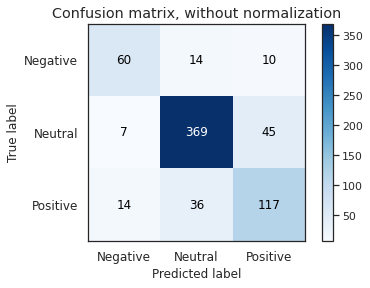

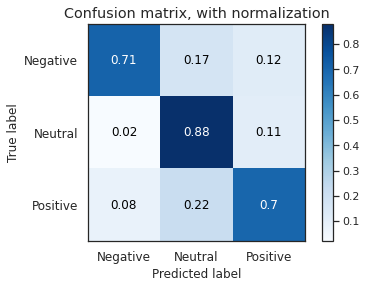

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.003113... Val Loss: 0.927618 Accuracy: 0.824405 F1 Score: 0.784940
Epoch: 27/30... Step: 20... Loss: 0.002428... Val Loss: 0.945239 Accuracy: 0.821429 F1 Score: 0.773994
Epoch: 27/30... Step: 30... Loss: 0.003346... Val Loss: 0.974371 Accuracy: 0.813988 F1 Score: 0.773145
Epoch: 27/30... Step: 40... Loss: 0.014447... Val Loss: 0.994167 Accuracy: 0.815476 F1 Score: 0.776313
Epoch: 27/30... Step: 50... Loss: 0.008203... Val Loss: 0.997544 Accuracy: 0.813988 F1 Score: 0.770877
Epoch: 27/30... Step: 60... Loss: 0.003025... Val Loss: 0.978291 Accuracy: 0.808036 F1 Score: 0.763725
Epoch: 27/30... Step: 70... Loss: 0.009710... Val Loss: 0.973910 Accuracy: 0.803571 F1 Score: 0.754251
Epoch: 27/30... Step: 80... Loss: 0.002126... Val Loss: 0.964631 Accuracy: 0.812500 F1 Score: 0.767090
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.81250000, Average f1: 0.76708958



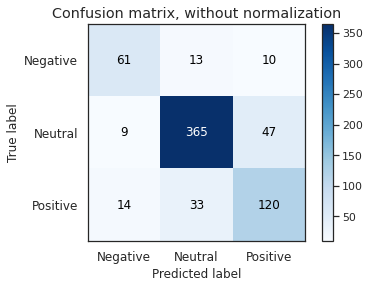

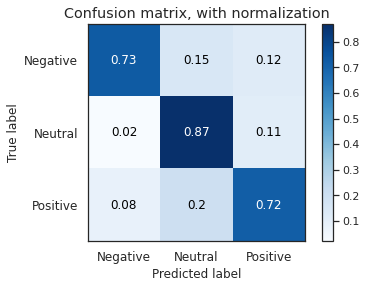

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.003008... Val Loss: 0.991007 Accuracy: 0.819940 F1 Score: 0.778609
Epoch: 28/30... Step: 20... Loss: 0.002599... Val Loss: 0.985212 Accuracy: 0.822917 F1 Score: 0.781299
Epoch: 28/30... Step: 30... Loss: 0.004188... Val Loss: 0.985612 Accuracy: 0.824405 F1 Score: 0.784105
Epoch: 28/30... Step: 40... Loss: 0.008277... Val Loss: 1.042057 Accuracy: 0.806548 F1 Score: 0.768153
Epoch: 28/30... Step: 50... Loss: 0.003638... Val Loss: 1.043708 Accuracy: 0.809524 F1 Score: 0.771995
Epoch: 28/30... Step: 60... Loss: 0.003182... Val Loss: 1.028987 Accuracy: 0.816964 F1 Score: 0.779198
Epoch: 28/30... Step: 70... Loss: 0.003688... Val Loss: 1.006131 Accuracy: 0.816964 F1 Score: 0.770985
Epoch: 28/30... Step: 80... Loss: 0.001605... Val Loss: 0.999467 Accuracy: 0.818452 F1 Score: 0.770056
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.81845238, Average f1: 0.77005648



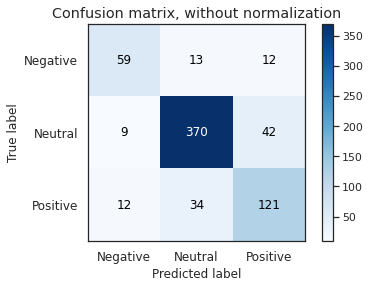

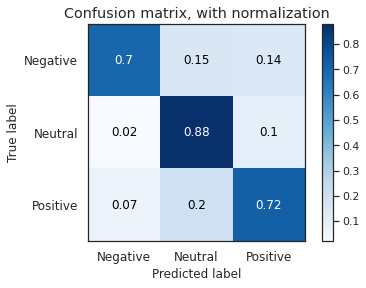

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.001995... Val Loss: 1.003603 Accuracy: 0.822917 F1 Score: 0.776200
Epoch: 29/30... Step: 20... Loss: 0.002561... Val Loss: 1.001720 Accuracy: 0.822917 F1 Score: 0.775731
Epoch: 29/30... Step: 30... Loss: 0.002190... Val Loss: 1.009098 Accuracy: 0.825893 F1 Score: 0.780104
Epoch: 29/30... Step: 40... Loss: 0.015250... Val Loss: 1.017259 Accuracy: 0.824405 F1 Score: 0.780588
Epoch: 29/30... Step: 50... Loss: 0.004518... Val Loss: 1.025772 Accuracy: 0.821429 F1 Score: 0.778758
Epoch: 29/30... Step: 60... Loss: 0.002231... Val Loss: 1.029334 Accuracy: 0.821429 F1 Score: 0.777745
Epoch: 29/30... Step: 70... Loss: 0.013982... Val Loss: 1.022804 Accuracy: 0.824405 F1 Score: 0.781321
Epoch: 29/30... Step: 80... Loss: 0.001828... Val Loss: 1.024232 Accuracy: 0.821429 F1 Score: 0.776797
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.82142857, Average f1: 0.77679726



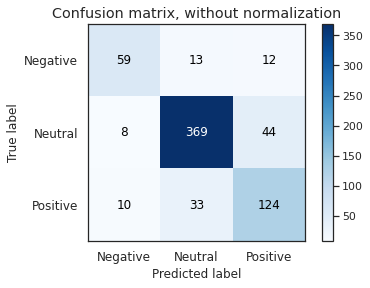

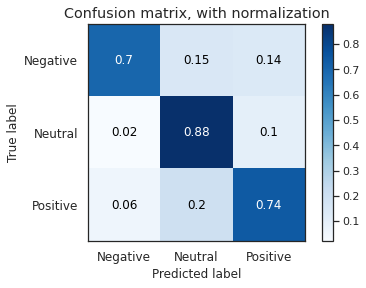

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.001658... Val Loss: 1.039620 Accuracy: 0.813988 F1 Score: 0.767938
Epoch: 30/30... Step: 20... Loss: 0.001974... Val Loss: 1.032683 Accuracy: 0.818452 F1 Score: 0.772451
Epoch: 30/30... Step: 30... Loss: 0.002359... Val Loss: 1.029603 Accuracy: 0.818452 F1 Score: 0.773611
Epoch: 30/30... Step: 40... Loss: 0.007183... Val Loss: 1.037443 Accuracy: 0.818452 F1 Score: 0.773611
Epoch: 30/30... Step: 50... Loss: 0.002764... Val Loss: 1.048354 Accuracy: 0.821429 F1 Score: 0.777582
Epoch: 30/30... Step: 60... Loss: 0.001767... Val Loss: 1.052676 Accuracy: 0.822917 F1 Score: 0.780333
Epoch: 30/30... Step: 70... Loss: 0.004937... Val Loss: 1.055710 Accuracy: 0.824405 F1 Score: 0.782326
Epoch: 30/30... Step: 80... Loss: 0.001161... Val Loss: 1.059075 Accuracy: 0.822917 F1 Score: 0.778718
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.82291667, Average f1: 0.77871849



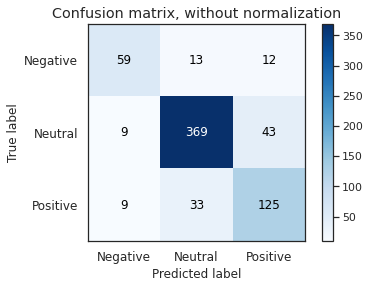

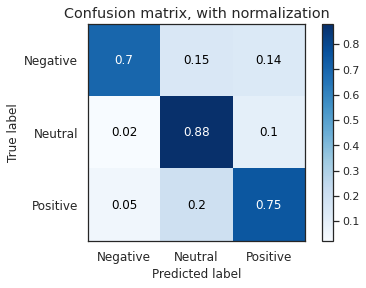

In [56]:
train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

### Download GloVe files

In [57]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [58]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [59]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

6406 words found out of 7135 words in vocab.
(7136, 300)


In [60]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(lstm_size, dense_size)
        # self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        # dense_out = self.fc1(lstm_out)
        # out = self.fc2(dense_out)
        out = self.fc(lstm_out)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [61]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(7136, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 1.115844... Val Loss: 1.109477 Accuracy: 0.133929 F1 Score: 0.090101
Epoch: 1/30... Step: 20... Loss: 1.081188... Val Loss: 1.085221 Accuracy: 0.580357 F1 Score: 0.286556
Epoch: 1/30... Step: 30... Loss: 1.062147... Val Loss: 1.055588 Accuracy: 0.626488 F1 Score: 0.257021
Epoch: 1/30... Step: 40... Loss: 1.047421... Val Loss: 1.016933 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 50... Loss: 1.025890... Val Loss: 0.964164 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 60... Loss: 0.871688... Val Loss: 0.918112 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 70... Loss: 1.016104... Val Loss: 0.906691 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 1/30... Step: 80... Loss: 0.899045... Val Loss: 0.897166 Accuracy: 0.626488 F1 Score: 0.256786
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.62648810, Average f1: 0.25678561



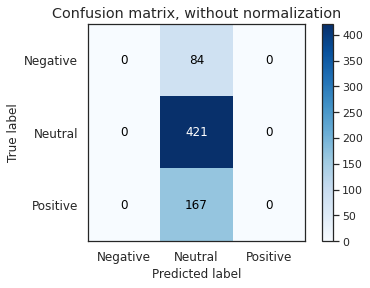

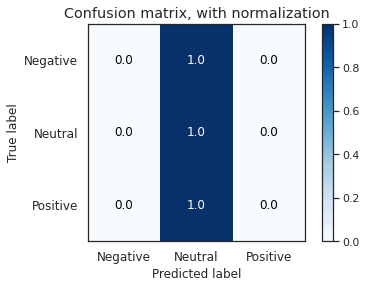

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.943495... Val Loss: 0.889043 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 20... Loss: 0.793534... Val Loss: 0.872797 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 30... Loss: 0.918611... Val Loss: 0.862652 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 40... Loss: 1.030203... Val Loss: 0.844941 Accuracy: 0.626488 F1 Score: 0.256786
Epoch: 2/30... Step: 50... Loss: 0.940212... Val Loss: 0.831689 Accuracy: 0.627976 F1 Score: 0.260989
Epoch: 2/30... Step: 60... Loss: 0.733073... Val Loss: 0.821866 Accuracy: 0.635417 F1 Score: 0.285482
Epoch: 2/30... Step: 70... Loss: 0.838535... Val Loss: 0.808289 Accuracy: 0.648810 F1 Score: 0.322753
Epoch: 2/30... Step: 80... Loss: 0.780137... Val Loss: 0.798078 Accuracy: 0.663690 F1 Score: 0.354175
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.66369048, Average f1: 0.35417517



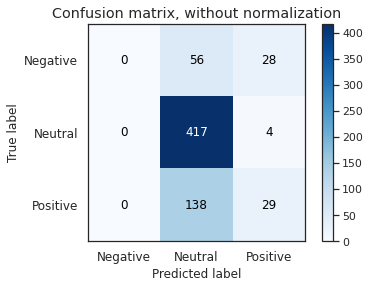

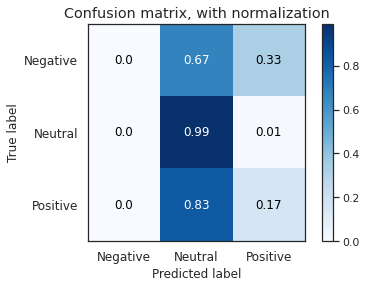

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.784770... Val Loss: 0.792657 Accuracy: 0.683036 F1 Score: 0.404262
Epoch: 3/30... Step: 20... Loss: 0.596170... Val Loss: 0.812822 Accuracy: 0.671131 F1 Score: 0.377798
Epoch: 3/30... Step: 30... Loss: 0.828638... Val Loss: 0.785582 Accuracy: 0.705357 F1 Score: 0.438690
Epoch: 3/30... Step: 40... Loss: 1.012760... Val Loss: 0.778867 Accuracy: 0.696429 F1 Score: 0.425731
Epoch: 3/30... Step: 50... Loss: 0.829628... Val Loss: 0.779764 Accuracy: 0.691964 F1 Score: 0.416235
Epoch: 3/30... Step: 60... Loss: 0.652095... Val Loss: 0.789169 Accuracy: 0.690476 F1 Score: 0.437049
Epoch: 3/30... Step: 70... Loss: 0.745124... Val Loss: 0.770299 Accuracy: 0.696429 F1 Score: 0.425515
Epoch: 3/30... Step: 80... Loss: 0.726478... Val Loss: 0.769915 Accuracy: 0.688988 F1 Score: 0.430495
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.68898810, Average f1: 0.43049500



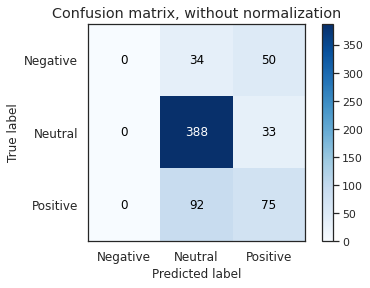

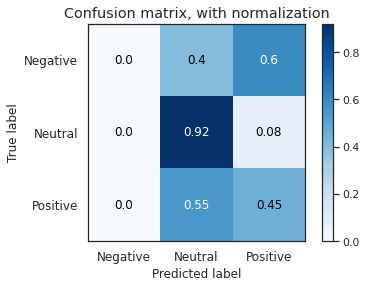

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.735977... Val Loss: 0.778159 Accuracy: 0.681548 F1 Score: 0.434394
Epoch: 4/30... Step: 20... Loss: 0.559886... Val Loss: 0.794097 Accuracy: 0.691964 F1 Score: 0.418714
Epoch: 4/30... Step: 30... Loss: 0.793057... Val Loss: 0.767207 Accuracy: 0.683036 F1 Score: 0.431932
Epoch: 4/30... Step: 40... Loss: 0.952375... Val Loss: 0.766678 Accuracy: 0.681548 F1 Score: 0.434542
Epoch: 4/30... Step: 50... Loss: 0.797109... Val Loss: 0.767169 Accuracy: 0.694940 F1 Score: 0.428454
Epoch: 4/30... Step: 60... Loss: 0.594769... Val Loss: 0.776559 Accuracy: 0.677083 F1 Score: 0.437767
Epoch: 4/30... Step: 70... Loss: 0.695956... Val Loss: 0.754901 Accuracy: 0.696429 F1 Score: 0.438824
Epoch: 4/30... Step: 80... Loss: 0.723668... Val Loss: 0.755136 Accuracy: 0.684524 F1 Score: 0.433707
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.68452381, Average f1: 0.43370731



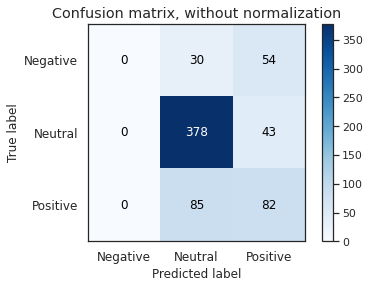

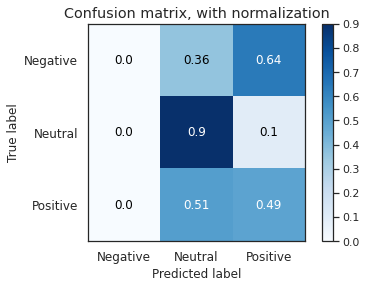

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.707476... Val Loss: 0.768921 Accuracy: 0.681548 F1 Score: 0.443136
Epoch: 5/30... Step: 20... Loss: 0.544176... Val Loss: 0.775262 Accuracy: 0.694940 F1 Score: 0.428454
Epoch: 5/30... Step: 30... Loss: 0.756961... Val Loss: 0.754106 Accuracy: 0.686012 F1 Score: 0.438733
Epoch: 5/30... Step: 40... Loss: 0.928547... Val Loss: 0.758567 Accuracy: 0.677083 F1 Score: 0.437131
Epoch: 5/30... Step: 50... Loss: 0.727350... Val Loss: 0.754385 Accuracy: 0.700893 F1 Score: 0.438475
Epoch: 5/30... Step: 60... Loss: 0.564495... Val Loss: 0.770510 Accuracy: 0.671131 F1 Score: 0.438167
Epoch: 5/30... Step: 70... Loss: 0.653116... Val Loss: 0.743164 Accuracy: 0.693452 F1 Score: 0.441508
Epoch: 5/30... Step: 80... Loss: 0.704459... Val Loss: 0.746393 Accuracy: 0.684524 F1 Score: 0.441070
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.68452381, Average f1: 0.44107038



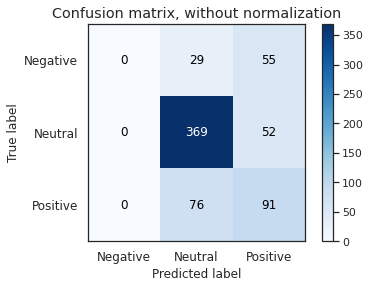

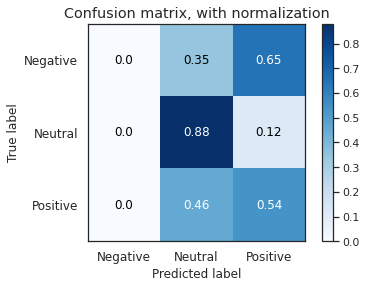

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.713387... Val Loss: 0.757235 Accuracy: 0.669643 F1 Score: 0.434637
Epoch: 6/30... Step: 20... Loss: 0.492265... Val Loss: 0.763256 Accuracy: 0.694940 F1 Score: 0.429134
Epoch: 6/30... Step: 30... Loss: 0.705396... Val Loss: 0.742604 Accuracy: 0.688988 F1 Score: 0.442963
Epoch: 6/30... Step: 40... Loss: 0.911653... Val Loss: 0.745663 Accuracy: 0.677083 F1 Score: 0.439394
Epoch: 6/30... Step: 50... Loss: 0.700500... Val Loss: 0.740028 Accuracy: 0.702381 F1 Score: 0.442466
Epoch: 6/30... Step: 60... Loss: 0.548792... Val Loss: 0.769475 Accuracy: 0.654762 F1 Score: 0.430369
Epoch: 6/30... Step: 70... Loss: 0.654109... Val Loss: 0.731211 Accuracy: 0.697917 F1 Score: 0.445597
Epoch: 6/30... Step: 80... Loss: 0.695274... Val Loss: 0.738505 Accuracy: 0.681548 F1 Score: 0.442663
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.68154762, Average f1: 0.44266348



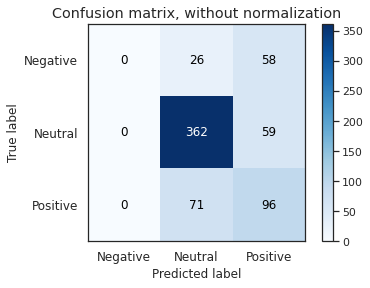

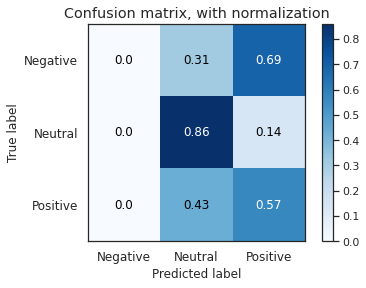

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.692033... Val Loss: 0.744408 Accuracy: 0.668155 F1 Score: 0.435430
Epoch: 7/30... Step: 20... Loss: 0.451574... Val Loss: 0.745043 Accuracy: 0.696429 F1 Score: 0.433976
Epoch: 7/30... Step: 30... Loss: 0.660302... Val Loss: 0.729722 Accuracy: 0.691964 F1 Score: 0.446341
Epoch: 7/30... Step: 40... Loss: 0.868284... Val Loss: 0.732078 Accuracy: 0.681548 F1 Score: 0.441176
Epoch: 7/30... Step: 50... Loss: 0.691931... Val Loss: 0.726377 Accuracy: 0.699405 F1 Score: 0.442489
Epoch: 7/30... Step: 60... Loss: 0.540615... Val Loss: 0.765842 Accuracy: 0.654762 F1 Score: 0.436425
Epoch: 7/30... Step: 70... Loss: 0.648959... Val Loss: 0.721371 Accuracy: 0.703869 F1 Score: 0.448593
Epoch: 7/30... Step: 80... Loss: 0.658176... Val Loss: 0.738049 Accuracy: 0.672619 F1 Score: 0.440426
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.67261905, Average f1: 0.44042636



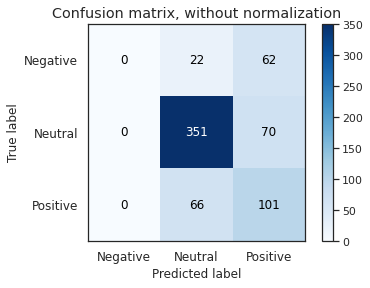

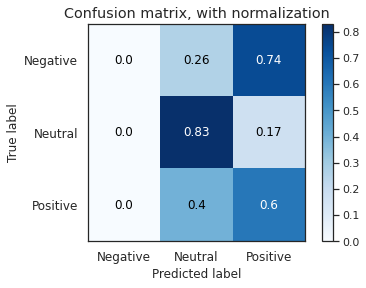

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.687503... Val Loss: 0.744196 Accuracy: 0.663690 F1 Score: 0.437063
Epoch: 8/30... Step: 20... Loss: 0.426887... Val Loss: 0.732848 Accuracy: 0.703869 F1 Score: 0.441472
Epoch: 8/30... Step: 30... Loss: 0.637355... Val Loss: 0.716377 Accuracy: 0.688988 F1 Score: 0.446230
Epoch: 8/30... Step: 40... Loss: 0.786129... Val Loss: 0.717892 Accuracy: 0.680060 F1 Score: 0.440909
Epoch: 8/30... Step: 50... Loss: 0.662705... Val Loss: 0.714786 Accuracy: 0.706845 F1 Score: 0.449773
Epoch: 8/30... Step: 60... Loss: 0.498558... Val Loss: 0.750008 Accuracy: 0.663690 F1 Score: 0.442420
Epoch: 8/30... Step: 70... Loss: 0.623056... Val Loss: 0.707329 Accuracy: 0.703869 F1 Score: 0.452575
Epoch: 8/30... Step: 80... Loss: 0.641596... Val Loss: 0.731314 Accuracy: 0.672619 F1 Score: 0.443190
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.67261905, Average f1: 0.44318986



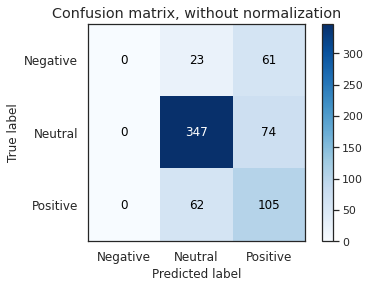

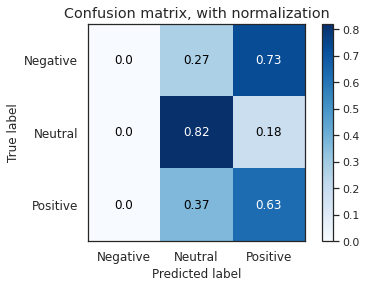

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.702278... Val Loss: 0.742607 Accuracy: 0.663690 F1 Score: 0.438806
Epoch: 9/30... Step: 20... Loss: 0.400229... Val Loss: 0.723156 Accuracy: 0.715774 F1 Score: 0.452897
Epoch: 9/30... Step: 30... Loss: 0.653945... Val Loss: 0.702456 Accuracy: 0.687500 F1 Score: 0.448264
Epoch: 9/30... Step: 40... Loss: 0.756316... Val Loss: 0.699760 Accuracy: 0.690476 F1 Score: 0.450058
Epoch: 9/30... Step: 50... Loss: 0.641268... Val Loss: 0.700203 Accuracy: 0.708333 F1 Score: 0.449132
Epoch: 9/30... Step: 60... Loss: 0.485633... Val Loss: 0.742725 Accuracy: 0.660714 F1 Score: 0.442766
Epoch: 9/30... Step: 70... Loss: 0.583127... Val Loss: 0.693500 Accuracy: 0.714286 F1 Score: 0.461677
Epoch: 9/30... Step: 80... Loss: 0.638872... Val Loss: 0.745957 Accuracy: 0.666667 F1 Score: 0.447544
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.66666667, Average f1: 0.44754387



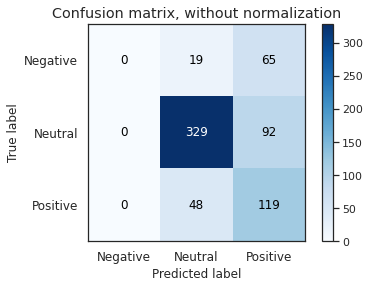

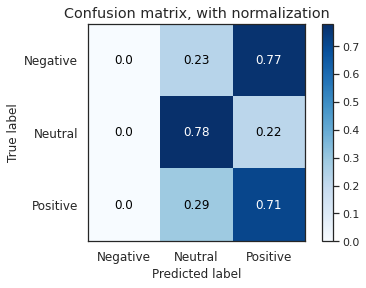

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.718971... Val Loss: 0.743141 Accuracy: 0.669643 F1 Score: 0.448785
Epoch: 10/30... Step: 20... Loss: 0.376254... Val Loss: 0.709666 Accuracy: 0.723214 F1 Score: 0.457212
Epoch: 10/30... Step: 30... Loss: 0.664115... Val Loss: 0.690971 Accuracy: 0.677083 F1 Score: 0.443070
Epoch: 10/30... Step: 40... Loss: 0.691711... Val Loss: 0.682319 Accuracy: 0.699405 F1 Score: 0.455628
Epoch: 10/30... Step: 50... Loss: 0.621715... Val Loss: 0.684224 Accuracy: 0.718750 F1 Score: 0.460932
Epoch: 10/30... Step: 60... Loss: 0.423736... Val Loss: 0.723843 Accuracy: 0.675595 F1 Score: 0.454346
Epoch: 10/30... Step: 70... Loss: 0.544458... Val Loss: 0.677927 Accuracy: 0.708333 F1 Score: 0.458876
Epoch: 10/30... Step: 80... Loss: 0.573245... Val Loss: 0.741431 Accuracy: 0.666667 F1 Score: 0.448605
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.66666667, Average f1: 0.44860502



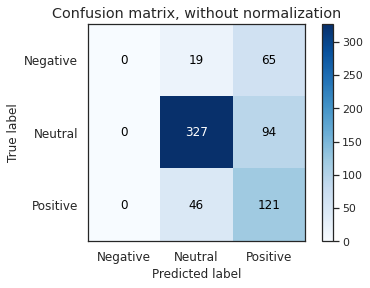

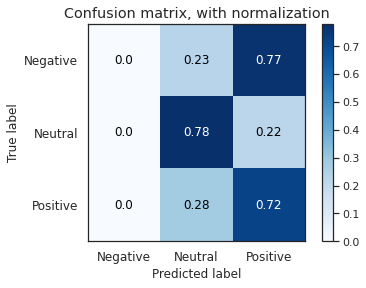

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.711953... Val Loss: 0.741327 Accuracy: 0.665179 F1 Score: 0.469288
Epoch: 11/30... Step: 20... Loss: 0.371795... Val Loss: 0.695613 Accuracy: 0.726190 F1 Score: 0.467989
Epoch: 11/30... Step: 30... Loss: 0.620782... Val Loss: 0.672411 Accuracy: 0.691964 F1 Score: 0.454801
Epoch: 11/30... Step: 40... Loss: 0.652368... Val Loss: 0.662975 Accuracy: 0.702381 F1 Score: 0.480435
Epoch: 11/30... Step: 50... Loss: 0.632829... Val Loss: 0.671658 Accuracy: 0.729167 F1 Score: 0.486648
Epoch: 11/30... Step: 60... Loss: 0.403041... Val Loss: 0.710318 Accuracy: 0.677083 F1 Score: 0.515361
Epoch: 11/30... Step: 70... Loss: 0.508900... Val Loss: 0.663126 Accuracy: 0.717262 F1 Score: 0.500868
Epoch: 11/30... Step: 80... Loss: 0.548627... Val Loss: 0.724001 Accuracy: 0.681548 F1 Score: 0.472275
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.68154762, Average f1: 0.47227531



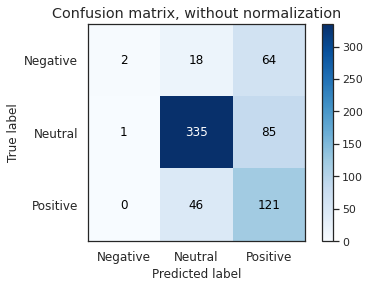

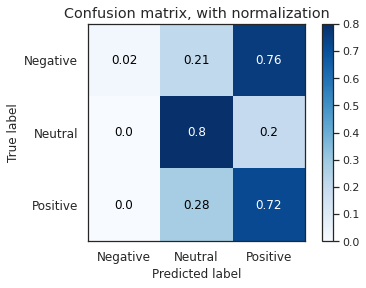

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.712810... Val Loss: 0.718354 Accuracy: 0.684524 F1 Score: 0.568756
Epoch: 12/30... Step: 20... Loss: 0.352026... Val Loss: 0.686805 Accuracy: 0.738095 F1 Score: 0.517858
Epoch: 12/30... Step: 30... Loss: 0.625424... Val Loss: 0.661807 Accuracy: 0.711310 F1 Score: 0.533066
Epoch: 12/30... Step: 40... Loss: 0.577336... Val Loss: 0.643494 Accuracy: 0.730655 F1 Score: 0.583365
Epoch: 12/30... Step: 50... Loss: 0.585371... Val Loss: 0.659759 Accuracy: 0.745536 F1 Score: 0.569300
Epoch: 12/30... Step: 60... Loss: 0.387961... Val Loss: 0.703722 Accuracy: 0.688988 F1 Score: 0.569179
Epoch: 12/30... Step: 70... Loss: 0.472255... Val Loss: 0.647715 Accuracy: 0.738095 F1 Score: 0.565179
Epoch: 12/30... Step: 80... Loss: 0.531980... Val Loss: 0.718996 Accuracy: 0.697917 F1 Score: 0.549906
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.69791667, Average f1: 0.54990624



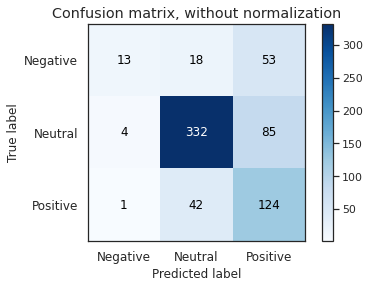

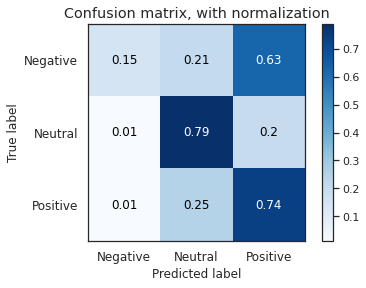

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.712679... Val Loss: 0.706411 Accuracy: 0.706845 F1 Score: 0.630415
Epoch: 13/30... Step: 20... Loss: 0.313547... Val Loss: 0.670211 Accuracy: 0.747024 F1 Score: 0.572240
Epoch: 13/30... Step: 30... Loss: 0.627120... Val Loss: 0.643310 Accuracy: 0.730655 F1 Score: 0.595357
Epoch: 13/30... Step: 40... Loss: 0.526807... Val Loss: 0.630309 Accuracy: 0.750000 F1 Score: 0.644556
Epoch: 13/30... Step: 50... Loss: 0.551618... Val Loss: 0.646529 Accuracy: 0.764881 F1 Score: 0.637699
Epoch: 13/30... Step: 60... Loss: 0.334057... Val Loss: 0.687973 Accuracy: 0.723214 F1 Score: 0.642472
Epoch: 13/30... Step: 70... Loss: 0.397465... Val Loss: 0.639537 Accuracy: 0.747024 F1 Score: 0.613952
Epoch: 13/30... Step: 80... Loss: 0.503024... Val Loss: 0.696678 Accuracy: 0.723214 F1 Score: 0.605965
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.72321429, Average f1: 0.60596489



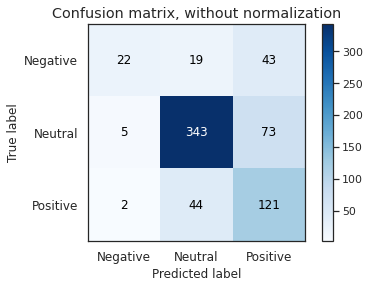

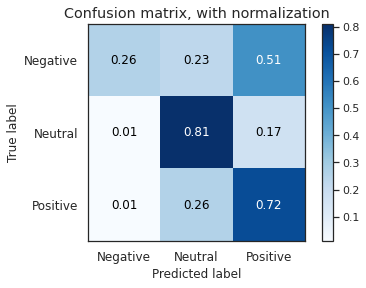

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.699699... Val Loss: 0.695005 Accuracy: 0.721726 F1 Score: 0.641591
Epoch: 14/30... Step: 20... Loss: 0.261452... Val Loss: 0.653917 Accuracy: 0.764881 F1 Score: 0.615398
Epoch: 14/30... Step: 30... Loss: 0.589870... Val Loss: 0.631916 Accuracy: 0.736607 F1 Score: 0.627770
Epoch: 14/30... Step: 40... Loss: 0.506353... Val Loss: 0.619777 Accuracy: 0.750000 F1 Score: 0.647602
Epoch: 14/30... Step: 50... Loss: 0.485965... Val Loss: 0.636543 Accuracy: 0.766369 F1 Score: 0.652416
Epoch: 14/30... Step: 60... Loss: 0.308947... Val Loss: 0.699891 Accuracy: 0.720238 F1 Score: 0.648468
Epoch: 14/30... Step: 70... Loss: 0.377097... Val Loss: 0.635059 Accuracy: 0.757440 F1 Score: 0.644824
Epoch: 14/30... Step: 80... Loss: 0.433821... Val Loss: 0.669744 Accuracy: 0.730655 F1 Score: 0.625583
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.73065476, Average f1: 0.62558277



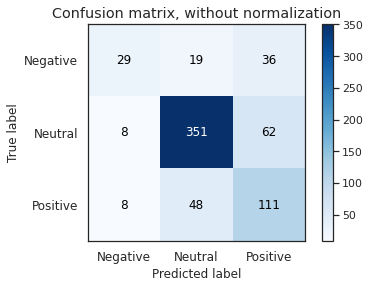

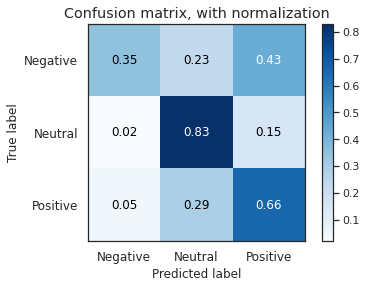

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.613121... Val Loss: 0.680766 Accuracy: 0.732143 F1 Score: 0.650642
Epoch: 15/30... Step: 20... Loss: 0.191794... Val Loss: 0.645383 Accuracy: 0.773810 F1 Score: 0.649363
Epoch: 15/30... Step: 30... Loss: 0.565624... Val Loss: 0.620010 Accuracy: 0.757440 F1 Score: 0.667298
Epoch: 15/30... Step: 40... Loss: 0.475950... Val Loss: 0.617722 Accuracy: 0.758929 F1 Score: 0.672371
Epoch: 15/30... Step: 50... Loss: 0.475427... Val Loss: 0.629289 Accuracy: 0.781250 F1 Score: 0.687476
Epoch: 15/30... Step: 60... Loss: 0.272548... Val Loss: 0.697833 Accuracy: 0.724702 F1 Score: 0.649706
Epoch: 15/30... Step: 70... Loss: 0.317673... Val Loss: 0.632052 Accuracy: 0.766369 F1 Score: 0.657754
Epoch: 15/30... Step: 80... Loss: 0.412590... Val Loss: 0.670033 Accuracy: 0.736607 F1 Score: 0.637973
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.73660714, Average f1: 0.63797261



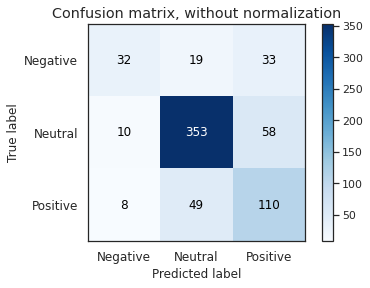

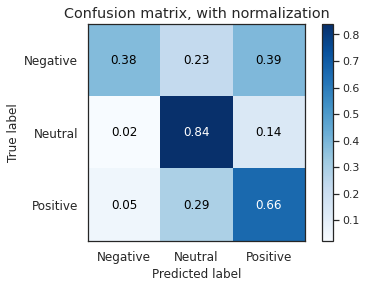

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.659453... Val Loss: 0.714899 Accuracy: 0.727679 F1 Score: 0.651144
Epoch: 16/30... Step: 20... Loss: 0.163978... Val Loss: 0.646539 Accuracy: 0.767857 F1 Score: 0.643604
Epoch: 16/30... Step: 30... Loss: 0.592096... Val Loss: 0.642526 Accuracy: 0.739583 F1 Score: 0.643580
Epoch: 16/30... Step: 40... Loss: 0.430281... Val Loss: 0.612493 Accuracy: 0.763393 F1 Score: 0.674255
Epoch: 16/30... Step: 50... Loss: 0.412201... Val Loss: 0.630593 Accuracy: 0.785714 F1 Score: 0.692720
Epoch: 16/30... Step: 60... Loss: 0.248554... Val Loss: 0.744736 Accuracy: 0.717262 F1 Score: 0.645370
Epoch: 16/30... Step: 70... Loss: 0.271361... Val Loss: 0.658718 Accuracy: 0.760417 F1 Score: 0.647172
Epoch: 16/30... Step: 80... Loss: 0.374639... Val Loss: 0.669841 Accuracy: 0.742560 F1 Score: 0.650902
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.74255952, Average f1: 0.65090239



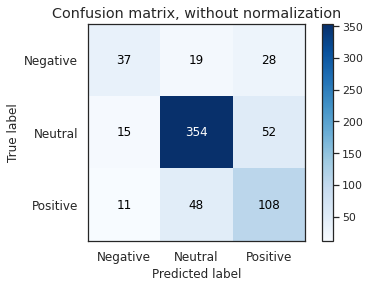

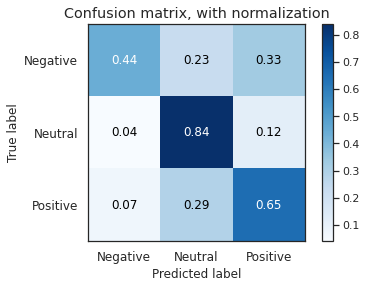

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.602162... Val Loss: 0.725385 Accuracy: 0.732143 F1 Score: 0.650752
Epoch: 17/30... Step: 20... Loss: 0.148700... Val Loss: 0.652441 Accuracy: 0.773810 F1 Score: 0.663948
Epoch: 17/30... Step: 30... Loss: 0.536375... Val Loss: 0.642089 Accuracy: 0.751488 F1 Score: 0.660693
Epoch: 17/30... Step: 40... Loss: 0.412927... Val Loss: 0.628383 Accuracy: 0.764881 F1 Score: 0.686555
Epoch: 17/30... Step: 50... Loss: 0.381316... Val Loss: 0.629055 Accuracy: 0.781250 F1 Score: 0.691114
Epoch: 17/30... Step: 60... Loss: 0.203865... Val Loss: 0.715032 Accuracy: 0.729167 F1 Score: 0.649939
Epoch: 17/30... Step: 70... Loss: 0.228130... Val Loss: 0.661054 Accuracy: 0.763393 F1 Score: 0.659013
Epoch: 17/30... Step: 80... Loss: 0.327161... Val Loss: 0.661465 Accuracy: 0.751488 F1 Score: 0.669374
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.75148810, Average f1: 0.66937350



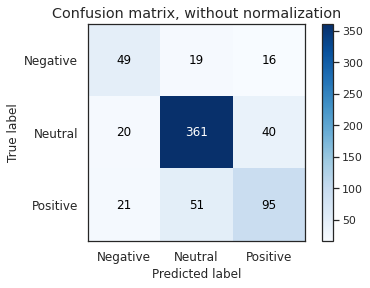

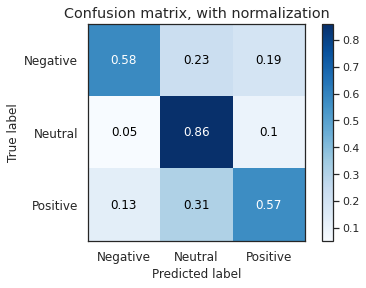

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.611573... Val Loss: 0.736080 Accuracy: 0.730655 F1 Score: 0.642388
Epoch: 18/30... Step: 20... Loss: 0.140744... Val Loss: 0.668107 Accuracy: 0.770833 F1 Score: 0.661928
Epoch: 18/30... Step: 30... Loss: 0.506922... Val Loss: 0.666884 Accuracy: 0.751488 F1 Score: 0.664588
Epoch: 18/30... Step: 40... Loss: 0.362004... Val Loss: 0.631648 Accuracy: 0.763393 F1 Score: 0.683994
Epoch: 18/30... Step: 50... Loss: 0.404207... Val Loss: 0.660175 Accuracy: 0.782738 F1 Score: 0.686975
Epoch: 18/30... Step: 60... Loss: 0.202028... Val Loss: 0.799082 Accuracy: 0.711310 F1 Score: 0.634613
Epoch: 18/30... Step: 70... Loss: 0.238564... Val Loss: 0.681887 Accuracy: 0.761905 F1 Score: 0.665019
Epoch: 18/30... Step: 80... Loss: 0.302725... Val Loss: 0.669954 Accuracy: 0.757440 F1 Score: 0.670840
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.75744048, Average f1: 0.67083984



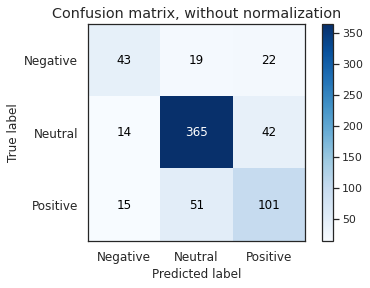

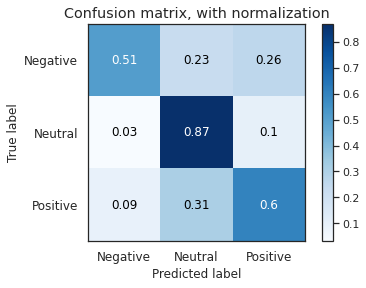

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.508853... Val Loss: 0.680591 Accuracy: 0.757440 F1 Score: 0.674408
Epoch: 19/30... Step: 20... Loss: 0.111092... Val Loss: 0.663453 Accuracy: 0.776786 F1 Score: 0.667643
Epoch: 19/30... Step: 30... Loss: 0.551034... Val Loss: 0.683559 Accuracy: 0.747024 F1 Score: 0.648105
Epoch: 19/30... Step: 40... Loss: 0.349388... Val Loss: 0.628848 Accuracy: 0.773810 F1 Score: 0.696977
Epoch: 19/30... Step: 50... Loss: 0.344313... Val Loss: 0.672252 Accuracy: 0.769345 F1 Score: 0.661642
Epoch: 19/30... Step: 60... Loss: 0.195596... Val Loss: 0.855807 Accuracy: 0.709821 F1 Score: 0.639259
Epoch: 19/30... Step: 70... Loss: 0.175496... Val Loss: 0.673256 Accuracy: 0.770833 F1 Score: 0.677401
Epoch: 19/30... Step: 80... Loss: 0.286953... Val Loss: 0.675867 Accuracy: 0.757440 F1 Score: 0.671012
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.75744048, Average f1: 0.67101167



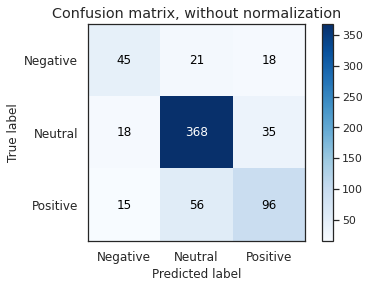

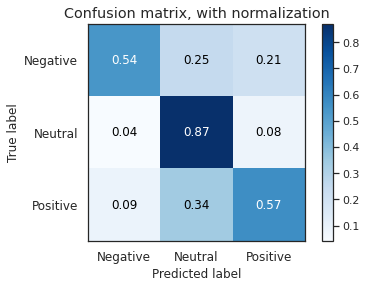

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.590502... Val Loss: 0.746235 Accuracy: 0.742560 F1 Score: 0.659807
Epoch: 20/30... Step: 20... Loss: 0.135950... Val Loss: 0.665997 Accuracy: 0.784226 F1 Score: 0.688231
Epoch: 20/30... Step: 30... Loss: 0.500463... Val Loss: 0.721123 Accuracy: 0.741071 F1 Score: 0.648267
Epoch: 20/30... Step: 40... Loss: 0.323220... Val Loss: 0.638690 Accuracy: 0.769345 F1 Score: 0.687978
Epoch: 20/30... Step: 50... Loss: 0.323318... Val Loss: 0.668107 Accuracy: 0.779762 F1 Score: 0.691247
Epoch: 20/30... Step: 60... Loss: 0.124302... Val Loss: 0.906807 Accuracy: 0.709821 F1 Score: 0.638931
Epoch: 20/30... Step: 70... Loss: 0.193722... Val Loss: 0.652054 Accuracy: 0.784226 F1 Score: 0.705127
Epoch: 20/30... Step: 80... Loss: 0.346029... Val Loss: 0.739342 Accuracy: 0.735119 F1 Score: 0.647520
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.73511905, Average f1: 0.64752006



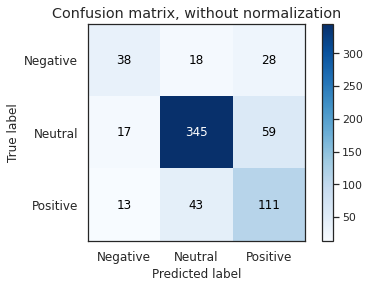

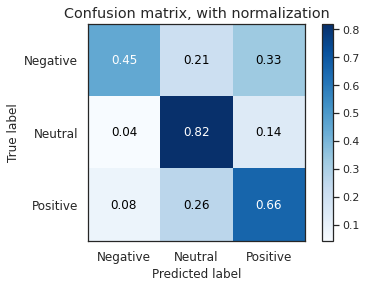

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.534216... Val Loss: 0.734953 Accuracy: 0.742560 F1 Score: 0.667104
Epoch: 21/30... Step: 20... Loss: 0.097862... Val Loss: 0.691821 Accuracy: 0.772321 F1 Score: 0.662778
Epoch: 21/30... Step: 30... Loss: 0.485565... Val Loss: 0.739261 Accuracy: 0.742560 F1 Score: 0.650040
Epoch: 21/30... Step: 40... Loss: 0.315281... Val Loss: 0.661303 Accuracy: 0.761905 F1 Score: 0.681915
Epoch: 21/30... Step: 50... Loss: 0.286868... Val Loss: 0.678989 Accuracy: 0.781250 F1 Score: 0.690904
Epoch: 21/30... Step: 60... Loss: 0.135521... Val Loss: 0.877634 Accuracy: 0.723214 F1 Score: 0.645832
Epoch: 21/30... Step: 70... Loss: 0.201215... Val Loss: 0.646887 Accuracy: 0.782738 F1 Score: 0.706940
Epoch: 21/30... Step: 80... Loss: 0.297542... Val Loss: 0.715334 Accuracy: 0.747024 F1 Score: 0.670644
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.74702381, Average f1: 0.67064360



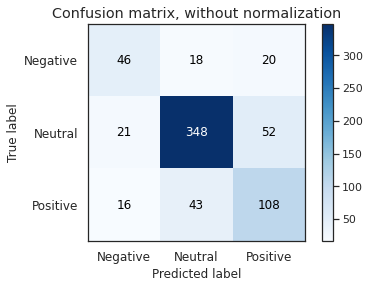

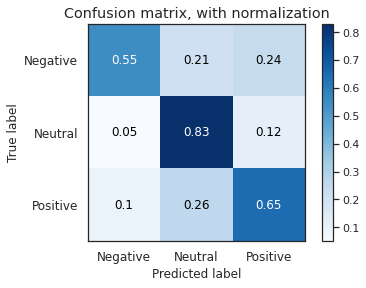

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.525874... Val Loss: 0.741797 Accuracy: 0.738095 F1 Score: 0.656509
Epoch: 22/30... Step: 20... Loss: 0.060357... Val Loss: 0.721414 Accuracy: 0.775298 F1 Score: 0.658207
Epoch: 22/30... Step: 30... Loss: 0.463304... Val Loss: 0.728956 Accuracy: 0.742560 F1 Score: 0.660433
Epoch: 22/30... Step: 40... Loss: 0.286364... Val Loss: 0.654376 Accuracy: 0.776786 F1 Score: 0.698336
Epoch: 22/30... Step: 50... Loss: 0.286133... Val Loss: 0.674689 Accuracy: 0.778274 F1 Score: 0.693070
Epoch: 22/30... Step: 60... Loss: 0.138273... Val Loss: 0.737010 Accuracy: 0.754464 F1 Score: 0.683326
Epoch: 22/30... Step: 70... Loss: 0.192509... Val Loss: 0.763952 Accuracy: 0.742560 F1 Score: 0.652584
Epoch: 22/30... Step: 80... Loss: 0.354928... Val Loss: 0.638091 Accuracy: 0.781250 F1 Score: 0.698891
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.78125000, Average f1: 0.69889108



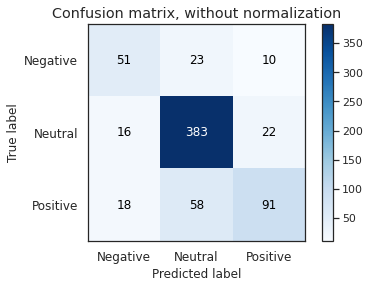

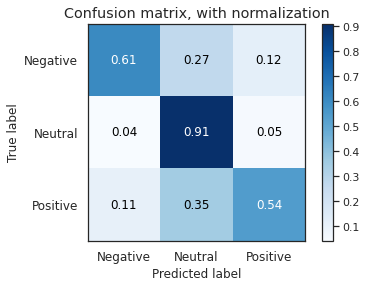

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.412593... Val Loss: 0.643216 Accuracy: 0.775298 F1 Score: 0.694379
Epoch: 23/30... Step: 20... Loss: 0.236871... Val Loss: 0.679288 Accuracy: 0.773810 F1 Score: 0.677408
Epoch: 23/30... Step: 30... Loss: 0.467919... Val Loss: 0.636611 Accuracy: 0.778274 F1 Score: 0.698900
Epoch: 23/30... Step: 40... Loss: 0.280227... Val Loss: 0.631053 Accuracy: 0.772321 F1 Score: 0.692975
Epoch: 23/30... Step: 50... Loss: 0.282959... Val Loss: 0.650861 Accuracy: 0.776786 F1 Score: 0.688185
Epoch: 23/30... Step: 60... Loss: 0.093420... Val Loss: 0.743515 Accuracy: 0.736607 F1 Score: 0.652281
Epoch: 23/30... Step: 70... Loss: 0.162156... Val Loss: 0.704883 Accuracy: 0.766369 F1 Score: 0.688269
Epoch: 23/30... Step: 80... Loss: 0.276967... Val Loss: 0.704984 Accuracy: 0.760417 F1 Score: 0.689813
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.76041667, Average f1: 0.68981319



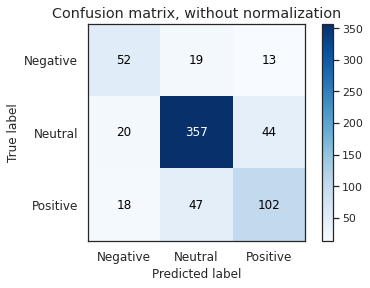

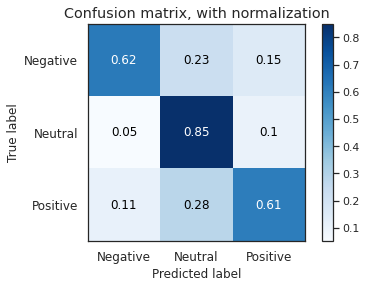

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.421012... Val Loss: 0.705405 Accuracy: 0.758929 F1 Score: 0.674512
Epoch: 24/30... Step: 20... Loss: 0.090614... Val Loss: 0.697867 Accuracy: 0.776786 F1 Score: 0.673631
Epoch: 24/30... Step: 30... Loss: 0.434135... Val Loss: 0.703211 Accuracy: 0.758929 F1 Score: 0.667386
Epoch: 24/30... Step: 40... Loss: 0.249584... Val Loss: 0.666181 Accuracy: 0.775298 F1 Score: 0.698921
Epoch: 24/30... Step: 50... Loss: 0.242829... Val Loss: 0.703412 Accuracy: 0.770833 F1 Score: 0.671827
Epoch: 24/30... Step: 60... Loss: 0.081124... Val Loss: 0.704514 Accuracy: 0.773810 F1 Score: 0.690710
Epoch: 24/30... Step: 70... Loss: 0.164209... Val Loss: 0.723464 Accuracy: 0.758929 F1 Score: 0.679966
Epoch: 24/30... Step: 80... Loss: 0.311212... Val Loss: 0.669649 Accuracy: 0.779762 F1 Score: 0.702931
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.77976190, Average f1: 0.70293094



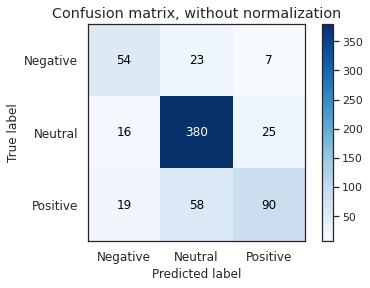

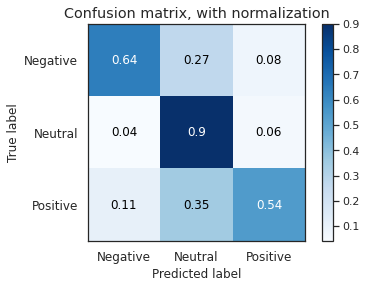

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.382029... Val Loss: 0.688803 Accuracy: 0.778274 F1 Score: 0.696118
Epoch: 25/30... Step: 20... Loss: 0.073500... Val Loss: 0.718219 Accuracy: 0.772321 F1 Score: 0.666551
Epoch: 25/30... Step: 30... Loss: 0.392443... Val Loss: 0.716411 Accuracy: 0.769345 F1 Score: 0.694099
Epoch: 25/30... Step: 40... Loss: 0.246643... Val Loss: 0.690546 Accuracy: 0.773810 F1 Score: 0.695943
Epoch: 25/30... Step: 50... Loss: 0.212463... Val Loss: 0.708336 Accuracy: 0.772321 F1 Score: 0.683767
Epoch: 25/30... Step: 60... Loss: 0.086436... Val Loss: 0.727641 Accuracy: 0.764881 F1 Score: 0.694483
Epoch: 25/30... Step: 70... Loss: 0.123250... Val Loss: 0.784966 Accuracy: 0.745536 F1 Score: 0.652393
Epoch: 25/30... Step: 80... Loss: 0.275997... Val Loss: 0.706304 Accuracy: 0.769345 F1 Score: 0.692284
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.76934524, Average f1: 0.69228352



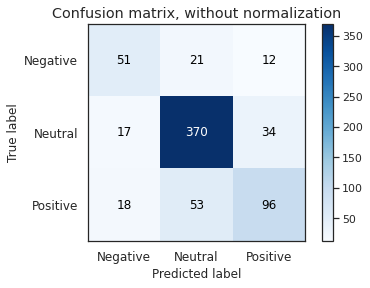

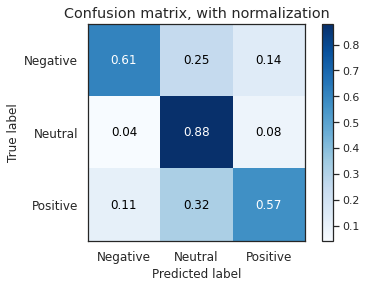

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.323423... Val Loss: 0.721238 Accuracy: 0.773810 F1 Score: 0.697600
Epoch: 26/30... Step: 20... Loss: 0.072310... Val Loss: 0.730880 Accuracy: 0.773810 F1 Score: 0.673901
Epoch: 26/30... Step: 30... Loss: 0.405965... Val Loss: 0.739188 Accuracy: 0.764881 F1 Score: 0.679205
Epoch: 26/30... Step: 40... Loss: 0.248148... Val Loss: 0.698771 Accuracy: 0.770833 F1 Score: 0.697083
Epoch: 26/30... Step: 50... Loss: 0.216322... Val Loss: 0.719380 Accuracy: 0.779762 F1 Score: 0.694672
Epoch: 26/30... Step: 60... Loss: 0.050895... Val Loss: 0.746077 Accuracy: 0.758929 F1 Score: 0.682881
Epoch: 26/30... Step: 70... Loss: 0.110639... Val Loss: 0.816917 Accuracy: 0.750000 F1 Score: 0.656288
Epoch: 26/30... Step: 80... Loss: 0.246856... Val Loss: 0.702059 Accuracy: 0.766369 F1 Score: 0.695806
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.76636905, Average f1: 0.69580572



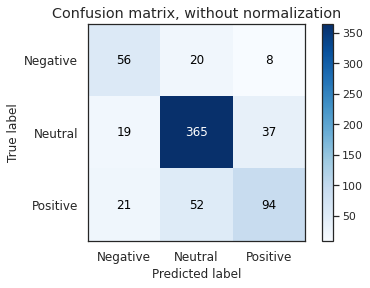

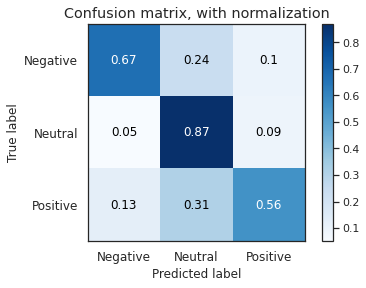

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.324227... Val Loss: 0.710062 Accuracy: 0.773810 F1 Score: 0.693810
Epoch: 27/30... Step: 20... Loss: 0.122751... Val Loss: 0.717538 Accuracy: 0.764881 F1 Score: 0.673307
Epoch: 27/30... Step: 30... Loss: 0.375639... Val Loss: 0.760791 Accuracy: 0.760417 F1 Score: 0.663012
Epoch: 27/30... Step: 40... Loss: 0.243564... Val Loss: 0.697651 Accuracy: 0.772321 F1 Score: 0.699537
Epoch: 27/30... Step: 50... Loss: 0.191685... Val Loss: 0.742367 Accuracy: 0.781250 F1 Score: 0.692855
Epoch: 27/30... Step: 60... Loss: 0.047096... Val Loss: 0.777775 Accuracy: 0.760417 F1 Score: 0.678923
Epoch: 27/30... Step: 70... Loss: 0.114657... Val Loss: 0.794978 Accuracy: 0.755952 F1 Score: 0.671277
Epoch: 27/30... Step: 80... Loss: 0.260000... Val Loss: 0.767653 Accuracy: 0.766369 F1 Score: 0.698822
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.76636905, Average f1: 0.69882161



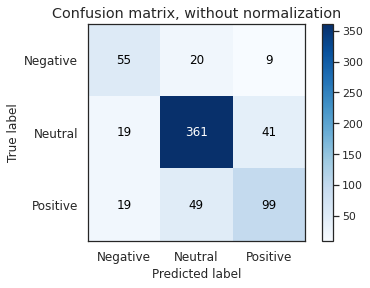

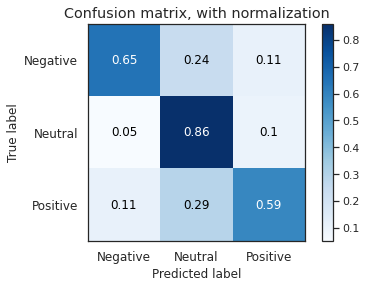

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.455352... Val Loss: 0.854016 Accuracy: 0.755952 F1 Score: 0.658627
Epoch: 28/30... Step: 20... Loss: 0.150600... Val Loss: 0.704396 Accuracy: 0.781250 F1 Score: 0.702940
Epoch: 28/30... Step: 30... Loss: 0.339701... Val Loss: 0.781599 Accuracy: 0.767857 F1 Score: 0.672088
Epoch: 28/30... Step: 40... Loss: 0.215263... Val Loss: 0.779447 Accuracy: 0.754464 F1 Score: 0.682443
Epoch: 28/30... Step: 50... Loss: 0.201664... Val Loss: 0.744909 Accuracy: 0.787202 F1 Score: 0.700345
Epoch: 28/30... Step: 60... Loss: 0.048633... Val Loss: 0.797131 Accuracy: 0.755952 F1 Score: 0.671590
Epoch: 28/30... Step: 70... Loss: 0.097168... Val Loss: 0.866638 Accuracy: 0.752976 F1 Score: 0.664434
Epoch: 28/30... Step: 80... Loss: 0.268493... Val Loss: 0.771350 Accuracy: 0.782738 F1 Score: 0.713317
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.78273810, Average f1: 0.71331735



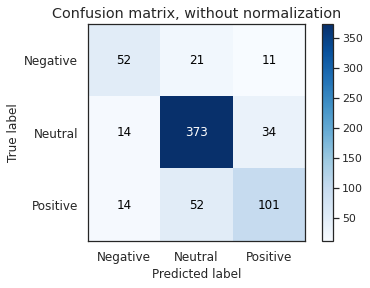

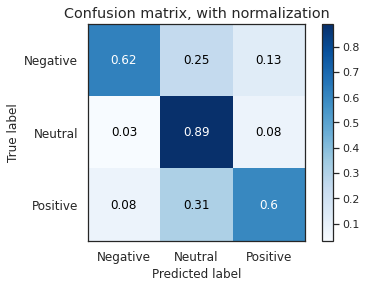

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.364915... Val Loss: 0.799587 Accuracy: 0.772321 F1 Score: 0.681736
Epoch: 29/30... Step: 20... Loss: 0.143832... Val Loss: 0.767409 Accuracy: 0.772321 F1 Score: 0.688125
Epoch: 29/30... Step: 30... Loss: 0.364546... Val Loss: 0.764324 Accuracy: 0.775298 F1 Score: 0.701470
Epoch: 29/30... Step: 40... Loss: 0.224442... Val Loss: 0.796158 Accuracy: 0.764881 F1 Score: 0.694980
Epoch: 29/30... Step: 50... Loss: 0.169474... Val Loss: 0.796040 Accuracy: 0.784226 F1 Score: 0.700669
Epoch: 29/30... Step: 60... Loss: 0.033844... Val Loss: 0.855325 Accuracy: 0.750000 F1 Score: 0.683078
Epoch: 29/30... Step: 70... Loss: 0.062449... Val Loss: 0.993156 Accuracy: 0.732143 F1 Score: 0.625464
Epoch: 29/30... Step: 80... Loss: 0.263762... Val Loss: 0.765084 Accuracy: 0.773810 F1 Score: 0.701514
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.77380952, Average f1: 0.70151448



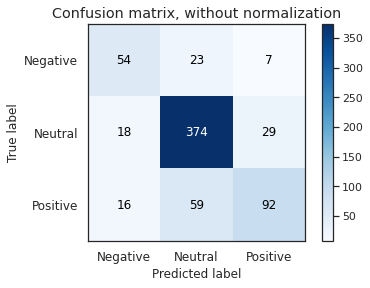

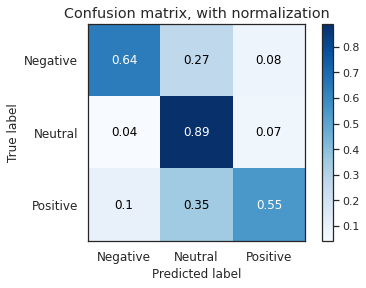

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.324195... Val Loss: 0.892759 Accuracy: 0.760417 F1 Score: 0.659631
Epoch: 30/30... Step: 20... Loss: 0.067245... Val Loss: 0.763460 Accuracy: 0.784226 F1 Score: 0.699494
Epoch: 30/30... Step: 30... Loss: 0.312250... Val Loss: 0.769072 Accuracy: 0.772321 F1 Score: 0.697129
Epoch: 30/30... Step: 40... Loss: 0.202001... Val Loss: 0.828674 Accuracy: 0.761905 F1 Score: 0.684867
Epoch: 30/30... Step: 50... Loss: 0.154832... Val Loss: 0.815057 Accuracy: 0.784226 F1 Score: 0.695313
Epoch: 30/30... Step: 60... Loss: 0.031495... Val Loss: 0.822106 Accuracy: 0.755952 F1 Score: 0.687261
Epoch: 30/30... Step: 70... Loss: 0.088208... Val Loss: 1.003229 Accuracy: 0.736607 F1 Score: 0.625139
Epoch: 30/30... Step: 80... Loss: 0.253530... Val Loss: 0.771335 Accuracy: 0.778274 F1 Score: 0.702439
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.77827381, Average f1: 0.70243860



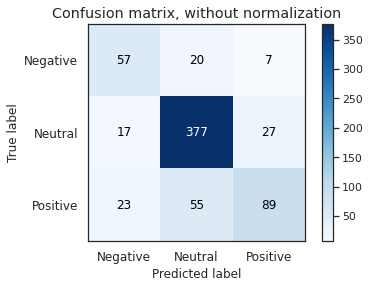

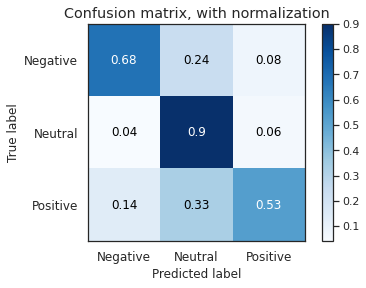

In [62]:
train_model(model)

## E. BERT Model

### Define functions

In [15]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_Bert, get_linear_schedule_with_warmup

In [16]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [17]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=80):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

### Input Data

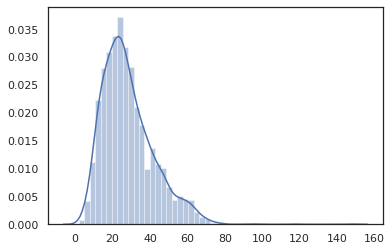

In [19]:
# Check the distribution to decide the maximum length
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [20]:
# Prepare training data
train_set = []
max_seq_length = 48

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

train_labels = train_df['label'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

### Define Bert Model

In [21]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [22]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple



tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
  

In [23]:
# Test Tokenizer - Own Implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
outputs = bert_model(text_ids, pad_masks, segment_ids)

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
text_ids (unsqueezed): 
 tensor([[  101,  7592,  1010,  2026,  3899,  20

### Train

In [24]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 20
batch_size = 32
patience = 7
warm_up_proportion = 0.1
max_grad_norm = 1.0
file_name = 'model'
bert_hidden_size = 768
bert_dense_size = 128

In [29]:
def train_bert(fold, train_indices, valid_indices):
    
    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    #bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, 3, dropout=0.1)
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Set Loss Function
    # If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    # Set Optimizer
    # Adam with parameter groups
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {}'.format(num_total_opt_steps))
    optimizer = AdamW_Bert(bert_model.parameters(), lr=learning_rate, correct_bias=False) # To reproduce BertAdam specific behavior set correct_bias=False
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)

            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch

            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = bert_model(x_ids, labels=y_truth)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        bert_model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                loss, logits = bert_model(x_ids, labels=y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        bert_model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            loss, logits = bert_model(x_ids, labels=y_truth)
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()

    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in train_valid_labels[valid_indices]]
    predicted_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()

[2020-07-08 21:48:02,214][INFO] ## ================     fold 0        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 21:48:26,817][INFO] ## epoch: 1, train loss: 0.61550342, valid loss: 0.49711867, acc: 0.86815, f1: 0.831177, best_f1: 0.83118
, last lr: 0.000098
[2020-07-08 21:48:26,863][INFO] ## ================     epoch 2        ===============


[2020-07-08 21:48:46,487][INFO] ## epoch: 2, train loss: 0.70474823, valid loss: 0.84563783, acc: 0.72211, f1: 0.467942, best_f1: 0.83118
, last lr: 0.000091
[2020-07-08 21:48:46,539][INFO] ## ================     epoch 3        ===============


[2020-07-08 21:49:05,600][INFO] ## epoch: 3, train loss: 0.66446247, valid loss: 0.62586099, acc: 0.78499, f1: 0.530792, best_f1: 0.83118
, last lr: 0.000084
[2020-07-08 21:49:05,651][INFO] ## ================     epoch 4        ===============


[2020-07-08 21:49:24,543][INFO] ## epoch: 4, train loss: 0.61881438, valid loss: 0.68493427, acc: 0.76268, f1: 0.498902, best_f1: 0.83118
, last lr: 0.000077
[2020-07-08 21:49:24,595][INFO] ## ================     epoch 5        ===============


[2020-07-08 21:49:43,551][INFO] ## epoch: 5, train loss: 0.62623918, valid loss: 0.54744961, acc: 0.80325, f1: 0.544972, best_f1: 0.83118
, last lr: 0.000070
[2020-07-08 21:49:43,608][INFO] ## ================     epoch 6        ===============


[2020-07-08 21:50:02,571][INFO] ## epoch: 6, train loss: 0.49999523, valid loss: 0.58285731, acc: 0.80730, f1: 0.548508, best_f1: 0.83118
, last lr: 0.000063
No handles with labels found to put in legend.


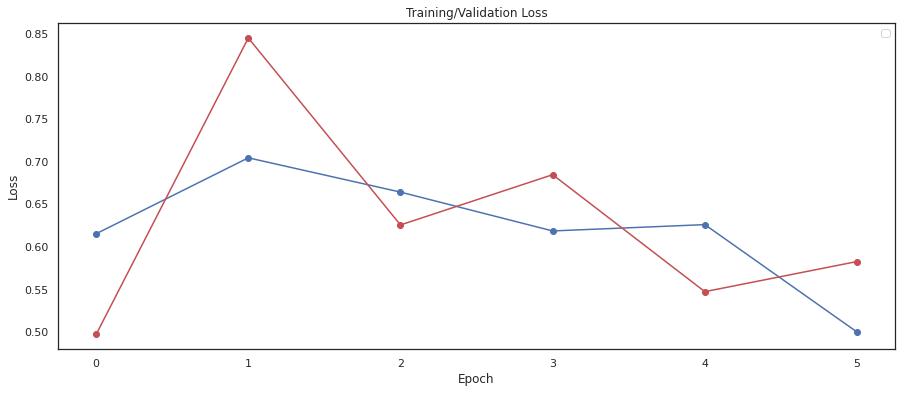

[2020-07-08 21:50:04,742][INFO] ## epoch: best, acc: 0.86815416, f1: 0.83117697, best_f1: 0.83117697



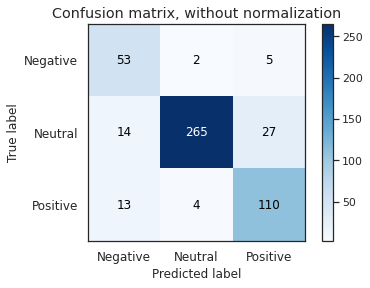

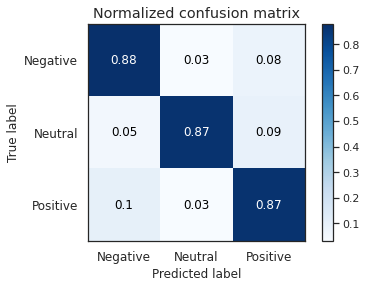

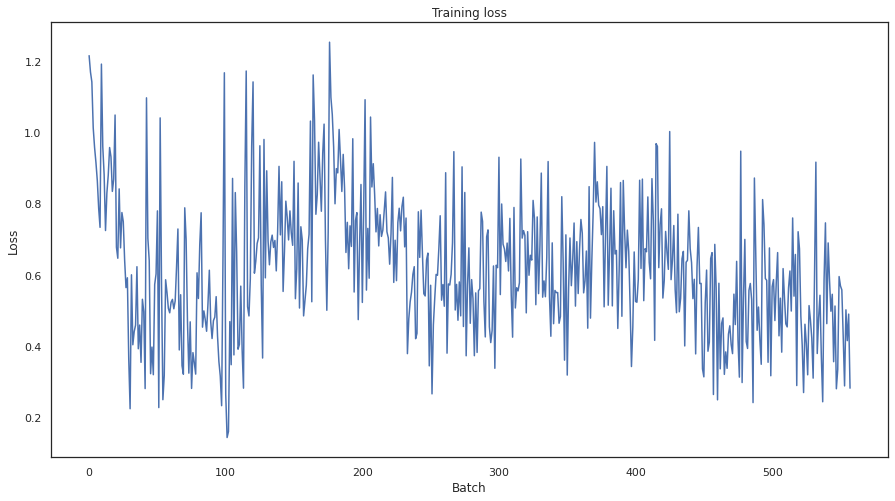

[2020-07-08 21:50:05,602][INFO] ## ================     fold 1        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 21:50:40,594][INFO] ## epoch: 1, train loss: 0.68820601, valid loss: 0.56181077, acc: 0.80527, f1: 0.747018, best_f1: 0.74702
, last lr: 0.000098
[2020-07-08 21:50:40,689][INFO] ## ================     epoch 2        ===============


[2020-07-08 21:51:02,006][INFO] ## epoch: 2, train loss: 0.53803589, valid loss: 0.52133617, acc: 0.83570, f1: 0.778272, best_f1: 0.77827
, last lr: 0.000091
[2020-07-08 21:51:02,058][INFO] ## ================     epoch 3        ===============


[2020-07-08 21:51:21,759][INFO] ## epoch: 3, train loss: 0.49735084, valid loss: 0.52421581, acc: 0.81542, f1: 0.763104, best_f1: 0.77827
, last lr: 0.000084
[2020-07-08 21:51:21,810][INFO] ## ================     epoch 4        ===============


[2020-07-08 21:51:42,496][INFO] ## epoch: 4, train loss: 0.46894153, valid loss: 0.54818128, acc: 0.84584, f1: 0.799078, best_f1: 0.79908
, last lr: 0.000077
[2020-07-08 21:51:42,547][INFO] ## ================     epoch 5        ===============


[2020-07-08 21:52:03,812][INFO] ## epoch: 5, train loss: 0.48291422, valid loss: 0.53273642, acc: 0.85396, f1: 0.808094, best_f1: 0.80809
, last lr: 0.000070
[2020-07-08 21:52:03,862][INFO] ## ================     epoch 6        ===============


[2020-07-08 21:52:25,195][INFO] ## epoch: 6, train loss: 0.44113801, valid loss: 0.50958137, acc: 0.86004, f1: 0.821477, best_f1: 0.82148
, last lr: 0.000063
[2020-07-08 21:52:25,244][INFO] ## ================     epoch 7        ===============


[2020-07-08 21:52:44,749][INFO] ## epoch: 7, train loss: 0.40341460, valid loss: 0.63211495, acc: 0.77890, f1: 0.756495, best_f1: 0.82148
, last lr: 0.000056
[2020-07-08 21:52:44,802][INFO] ## ================     epoch 8        ===============


[2020-07-08 21:53:05,483][INFO] ## epoch: 8, train loss: 0.36739900, valid loss: 0.45626592, acc: 0.86207, f1: 0.827845, best_f1: 0.82785
, last lr: 0.000049
[2020-07-08 21:53:05,537][INFO] ## ================     epoch 9        ===============


[2020-07-08 21:53:26,918][INFO] ## epoch: 9, train loss: 0.33773673, valid loss: 0.47156237, acc: 0.86613, f1: 0.832798, best_f1: 0.83280
, last lr: 0.000042
[2020-07-08 21:53:26,967][INFO] ## ================     epoch 10        ===============


[2020-07-08 21:53:48,784][INFO] ## epoch: 10, train loss: 0.30380644, valid loss: 0.48933127, acc: 0.87627, f1: 0.842746, best_f1: 0.84275
, last lr: 0.000035
[2020-07-08 21:53:48,836][INFO] ## ================     epoch 11        ===============


[2020-07-08 21:54:08,342][INFO] ## epoch: 11, train loss: 0.29648903, valid loss: 0.42465819, acc: 0.87830, f1: 0.841603, best_f1: 0.84275
, last lr: 0.000028
[2020-07-08 21:54:08,393][INFO] ## ================     epoch 12        ===============


[2020-07-08 21:54:29,073][INFO] ## epoch: 12, train loss: 0.25151152, valid loss: 0.42763811, acc: 0.88641, f1: 0.857198, best_f1: 0.85720
, last lr: 0.000021
[2020-07-08 21:54:29,122][INFO] ## ================     epoch 13        ===============


[2020-07-08 21:54:48,664][INFO] ## epoch: 13, train loss: 0.23041741, valid loss: 0.42506043, acc: 0.88032, f1: 0.843217, best_f1: 0.85720
, last lr: 0.000014
[2020-07-08 21:54:48,715][INFO] ## ================     epoch 14        ===============


[2020-07-08 21:55:07,669][INFO] ## epoch: 14, train loss: 0.20940231, valid loss: 0.42806682, acc: 0.88844, f1: 0.855125, best_f1: 0.85720
, last lr: 0.000007
[2020-07-08 21:55:07,720][INFO] ## ================     epoch 15        ===============


[2020-07-08 21:55:26,736][INFO] ## epoch: 15, train loss: 0.19513589, valid loss: 0.43952374, acc: 0.88438, f1: 0.846398, best_f1: 0.85720
, last lr: 0.000000
No handles with labels found to put in legend.


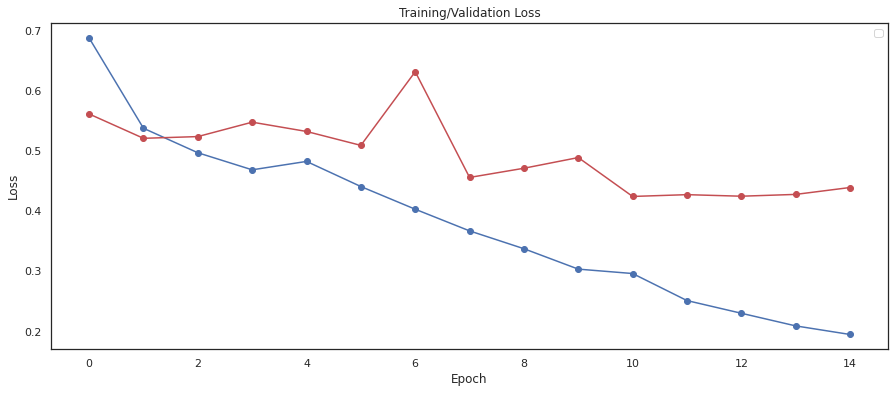

[2020-07-08 21:55:28,683][INFO] ## epoch: best, acc: 0.88640974, f1: 0.85719757, best_f1: 0.85719757



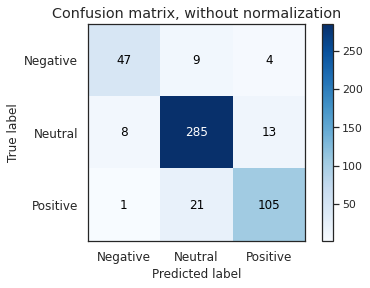

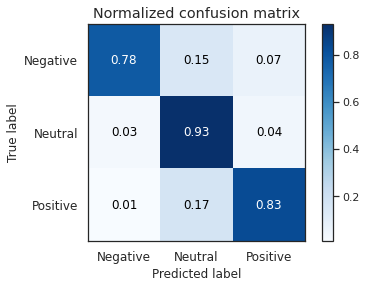

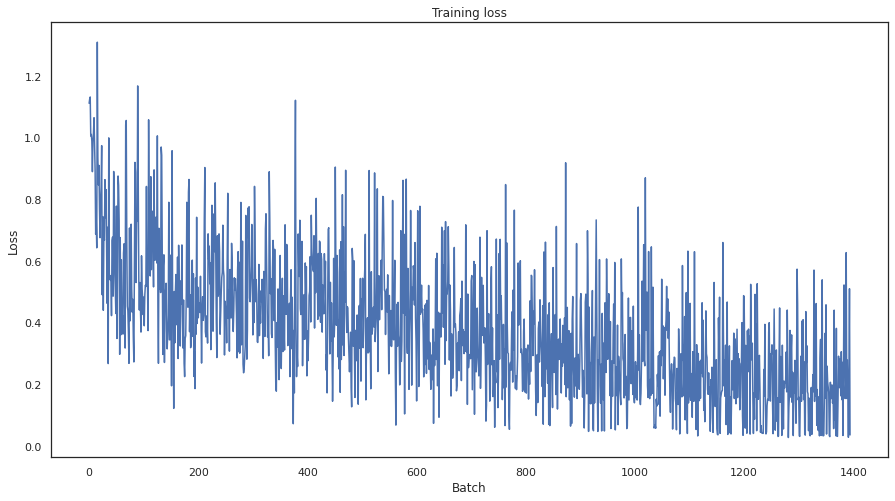

[2020-07-08 21:55:29,523][INFO] ## ================     fold 2        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 21:55:58,818][INFO] ## epoch: 1, train loss: 0.59207705, valid loss: 0.45399892, acc: 0.86613, f1: 0.820192, best_f1: 0.82019
, last lr: 0.000098
[2020-07-08 21:55:58,865][INFO] ## ================     epoch 2        ===============


[2020-07-08 21:56:18,426][INFO] ## epoch: 2, train loss: 0.38800166, valid loss: 0.61930350, acc: 0.83976, f1: 0.793236, best_f1: 0.82019
, last lr: 0.000091
[2020-07-08 21:56:18,478][INFO] ## ================     epoch 3        ===============


[2020-07-08 21:56:39,879][INFO] ## epoch: 3, train loss: 0.28853451, valid loss: 0.49559646, acc: 0.86815, f1: 0.829931, best_f1: 0.82993
, last lr: 0.000084
[2020-07-08 21:56:39,935][INFO] ## ================     epoch 4        ===============


[2020-07-08 21:56:59,539][INFO] ## epoch: 4, train loss: 0.20329188, valid loss: 0.58345161, acc: 0.84990, f1: 0.815432, best_f1: 0.82993
, last lr: 0.000077
[2020-07-08 21:56:59,591][INFO] ## ================     epoch 5        ===============


[2020-07-08 21:57:18,577][INFO] ## epoch: 5, train loss: 0.19242385, valid loss: 0.55193801, acc: 0.85598, f1: 0.816150, best_f1: 0.82993
, last lr: 0.000070
[2020-07-08 21:57:18,626][INFO] ## ================     epoch 6        ===============


[2020-07-08 21:57:39,608][INFO] ## epoch: 6, train loss: 0.16654437, valid loss: 0.47232569, acc: 0.87221, f1: 0.831165, best_f1: 0.83117
, last lr: 0.000063
[2020-07-08 21:57:39,665][INFO] ## ================     epoch 7        ===============


[2020-07-08 21:58:01,122][INFO] ## epoch: 7, train loss: 0.11964163, valid loss: 0.54240549, acc: 0.88844, f1: 0.858768, best_f1: 0.85877
, last lr: 0.000056
[2020-07-08 21:58:01,172][INFO] ## ================     epoch 8        ===============


[2020-07-08 21:58:22,552][INFO] ## epoch: 8, train loss: 0.09866154, valid loss: 0.57006161, acc: 0.89047, f1: 0.864242, best_f1: 0.86424
, last lr: 0.000049
[2020-07-08 21:58:22,607][INFO] ## ================     epoch 9        ===============


[2020-07-08 21:58:42,050][INFO] ## epoch: 9, train loss: 0.09467744, valid loss: 0.63099820, acc: 0.88032, f1: 0.843080, best_f1: 0.86424
, last lr: 0.000042
[2020-07-08 21:58:42,103][INFO] ## ================     epoch 10        ===============


[2020-07-08 21:59:01,050][INFO] ## epoch: 10, train loss: 0.07926638, valid loss: 0.62288000, acc: 0.88641, f1: 0.853401, best_f1: 0.86424
, last lr: 0.000035
[2020-07-08 21:59:01,101][INFO] ## ================     epoch 11        ===============


[2020-07-08 21:59:19,859][INFO] ## epoch: 11, train loss: 0.07144495, valid loss: 0.61996342, acc: 0.88032, f1: 0.848152, best_f1: 0.86424
, last lr: 0.000028
[2020-07-08 21:59:19,910][INFO] ## ================     epoch 12        ===============


[2020-07-08 21:59:38,733][INFO] ## epoch: 12, train loss: 0.07272638, valid loss: 0.60174995, acc: 0.88844, f1: 0.857201, best_f1: 0.86424
, last lr: 0.000021
[2020-07-08 21:59:38,784][INFO] ## ================     epoch 13        ===============


[2020-07-08 21:59:57,578][INFO] ## epoch: 13, train loss: 0.05750544, valid loss: 0.60473113, acc: 0.88641, f1: 0.851404, best_f1: 0.86424
, last lr: 0.000014
No handles with labels found to put in legend.


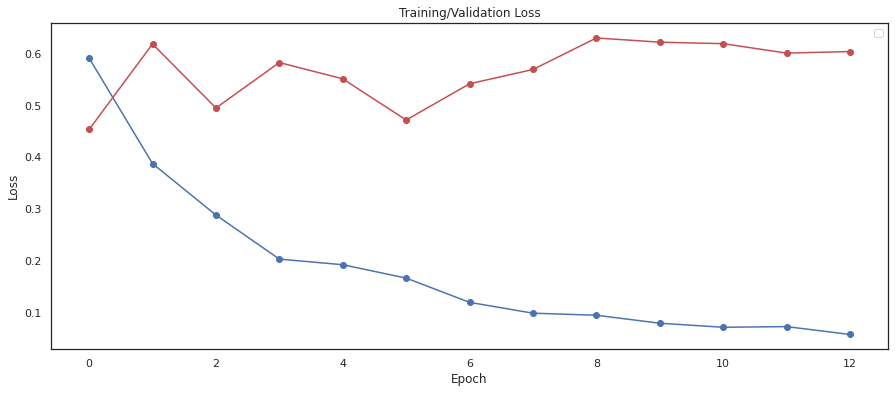

[2020-07-08 21:59:59,556][INFO] ## epoch: best, acc: 0.89046653, f1: 0.86424229, best_f1: 0.86424229



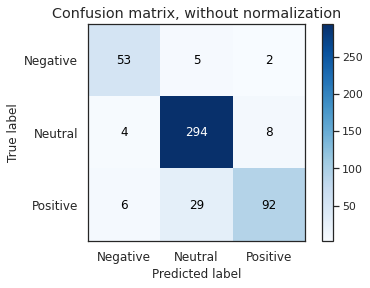

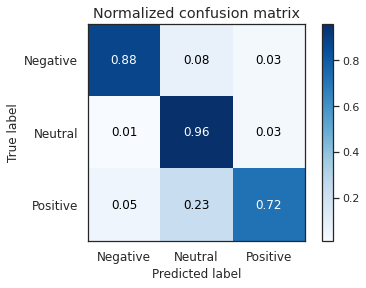

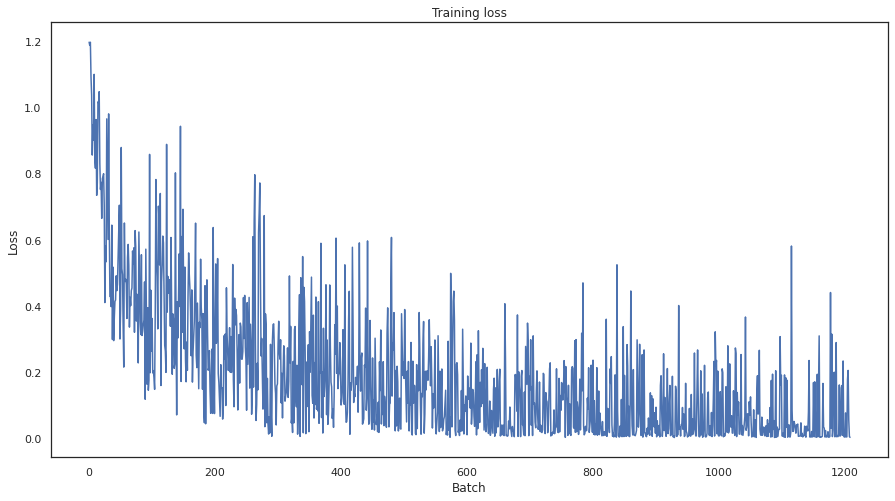

[2020-07-08 22:00:00,404][INFO] ## ================     fold 3        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 22:00:29,928][INFO] ## epoch: 1, train loss: 0.68248115, valid loss: 0.54594520, acc: 0.79108, f1: 0.704032, best_f1: 0.70403
, last lr: 0.000098
[2020-07-08 22:00:29,975][INFO] ## ================     epoch 2        ===============


[2020-07-08 22:00:49,620][INFO] ## epoch: 2, train loss: 0.62904082, valid loss: 0.94271831, acc: 0.62069, f1: 0.255319, best_f1: 0.70403
, last lr: 0.000091
[2020-07-08 22:00:49,675][INFO] ## ================     epoch 3        ===============


[2020-07-08 22:01:08,833][INFO] ## epoch: 3, train loss: 0.86162775, valid loss: 0.92162126, acc: 0.63286, f1: 0.293432, best_f1: 0.70403
, last lr: 0.000084
[2020-07-08 22:01:08,884][INFO] ## ================     epoch 4        ===============


[2020-07-08 22:01:27,876][INFO] ## epoch: 4, train loss: 0.92054618, valid loss: 0.94798348, acc: 0.62069, f1: 0.255319, best_f1: 0.70403
, last lr: 0.000077
[2020-07-08 22:01:27,926][INFO] ## ================     epoch 5        ===============


[2020-07-08 22:01:47,221][INFO] ## epoch: 5, train loss: 0.91136092, valid loss: 0.93489835, acc: 0.62069, f1: 0.255319, best_f1: 0.70403
, last lr: 0.000070
[2020-07-08 22:01:47,279][INFO] ## ================     epoch 6        ===============


[2020-07-08 22:02:06,124][INFO] ## epoch: 6, train loss: 0.89603031, valid loss: 0.74687664, acc: 0.72211, f1: 0.476968, best_f1: 0.70403
, last lr: 0.000063
No handles with labels found to put in legend.


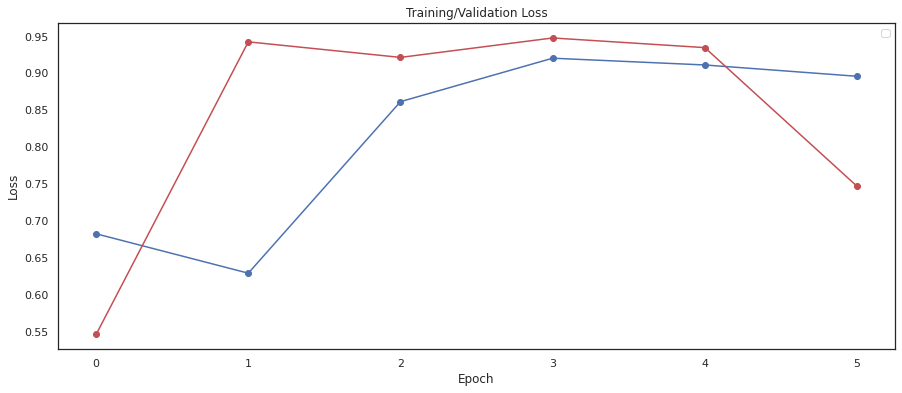

[2020-07-08 22:02:08,121][INFO] ## epoch: best, acc: 0.79107505, f1: 0.70403174, best_f1: 0.70403174



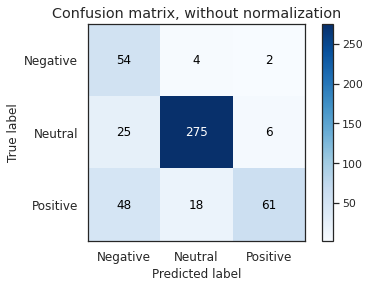

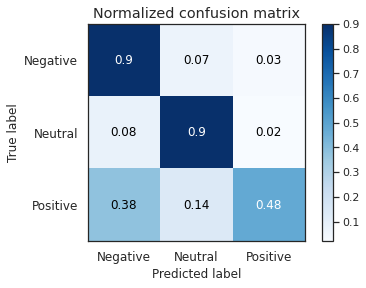

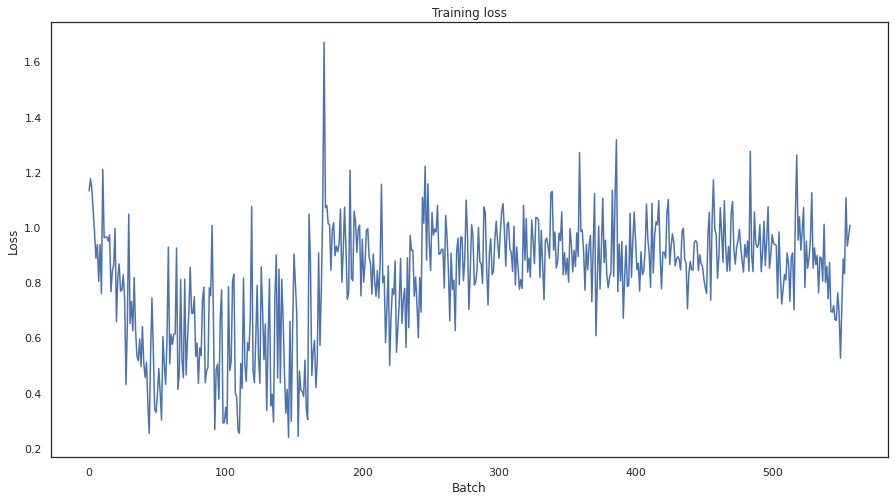

[2020-07-08 22:02:08,945][INFO] ## ================     fold 4        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 22:02:36,600][INFO] ## epoch: 1, train loss: 0.78166522, valid loss: 0.85507454, acc: 0.54065, f1: 0.383838, best_f1: 0.38384
, last lr: 0.000098
[2020-07-08 22:02:36,647][INFO] ## ================     epoch 2        ===============


[2020-07-08 22:02:58,079][INFO] ## epoch: 2, train loss: 0.70062391, valid loss: 0.77411388, acc: 0.67276, f1: 0.466296, best_f1: 0.46630
, last lr: 0.000091
[2020-07-08 22:02:58,134][INFO] ## ================     epoch 3        ===============


[2020-07-08 22:03:19,405][INFO] ## epoch: 3, train loss: 0.70168270, valid loss: 0.73530524, acc: 0.68699, f1: 0.467642, best_f1: 0.46764
, last lr: 0.000084
[2020-07-08 22:03:19,459][INFO] ## ================     epoch 4        ===============


[2020-07-08 22:03:39,048][INFO] ## epoch: 4, train loss: 0.70107552, valid loss: 0.75393918, acc: 0.67886, f1: 0.460888, best_f1: 0.46764
, last lr: 0.000077
[2020-07-08 22:03:39,098][INFO] ## ================     epoch 5        ===============


[2020-07-08 22:03:58,196][INFO] ## epoch: 5, train loss: 0.69535993, valid loss: 0.74737924, acc: 0.67683, f1: 0.461493, best_f1: 0.46764
, last lr: 0.000070
[2020-07-08 22:03:58,247][INFO] ## ================     epoch 6        ===============


[2020-07-08 22:04:17,560][INFO] ## epoch: 6, train loss: 0.69460428, valid loss: 0.75706135, acc: 0.66057, f1: 0.453308, best_f1: 0.46764
, last lr: 0.000063
[2020-07-08 22:04:17,615][INFO] ## ================     epoch 7        ===============


[2020-07-08 22:04:36,769][INFO] ## epoch: 7, train loss: 0.69304636, valid loss: 0.75249331, acc: 0.67073, f1: 0.458921, best_f1: 0.46764
, last lr: 0.000056
[2020-07-08 22:04:36,820][INFO] ## ================     epoch 8        ===============


[2020-07-08 22:04:55,870][INFO] ## epoch: 8, train loss: 0.69267527, valid loss: 0.78693236, acc: 0.64431, f1: 0.444521, best_f1: 0.46764
, last lr: 0.000049
No handles with labels found to put in legend.


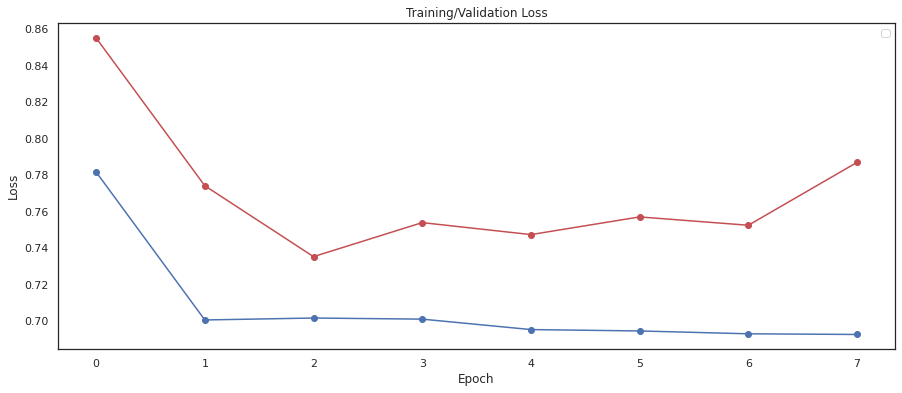

[2020-07-08 22:04:57,822][INFO] ## epoch: best, acc: 0.68699187, f1: 0.46764228, best_f1: 0.46764228



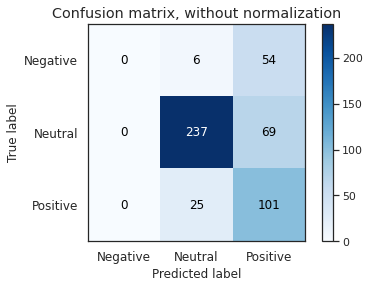

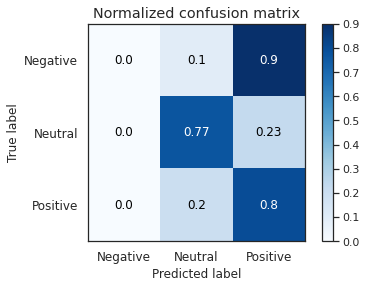

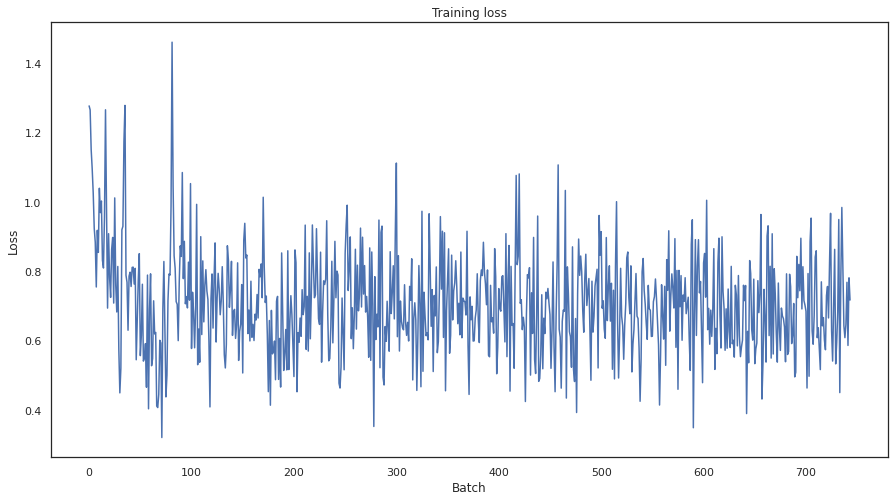

[2020-07-08 22:04:58,673][INFO] ## ================     fold 5        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 22:05:28,010][INFO] ## epoch: 1, train loss: 0.68874127, valid loss: 0.62709427, acc: 0.78049, f1: 0.672459, best_f1: 0.67246
, last lr: 0.000098
[2020-07-08 22:05:28,058][INFO] ## ================     epoch 2        ===============


[2020-07-08 22:05:47,753][INFO] ## epoch: 2, train loss: 0.75037305, valid loss: 0.96428178, acc: 0.62195, f1: 0.255639, best_f1: 0.67246
, last lr: 0.000091
[2020-07-08 22:05:47,804][INFO] ## ================     epoch 3        ===============


[2020-07-08 22:06:06,786][INFO] ## epoch: 3, train loss: 0.91668753, valid loss: 0.93724795, acc: 0.62195, f1: 0.255639, best_f1: 0.67246
, last lr: 0.000084
[2020-07-08 22:06:06,838][INFO] ## ================     epoch 4        ===============


[2020-07-08 22:06:25,747][INFO] ## epoch: 4, train loss: 0.91229727, valid loss: 0.95264360, acc: 0.62195, f1: 0.255639, best_f1: 0.67246
, last lr: 0.000077
[2020-07-08 22:06:25,796][INFO] ## ================     epoch 5        ===============


[2020-07-08 22:06:44,809][INFO] ## epoch: 5, train loss: 0.87380983, valid loss: 0.93525941, acc: 0.62195, f1: 0.255639, best_f1: 0.67246
, last lr: 0.000070
[2020-07-08 22:06:44,859][INFO] ## ================     epoch 6        ===============


[2020-07-08 22:07:03,846][INFO] ## epoch: 6, train loss: 0.92001772, valid loss: 0.94274557, acc: 0.62195, f1: 0.255639, best_f1: 0.67246
, last lr: 0.000063
No handles with labels found to put in legend.


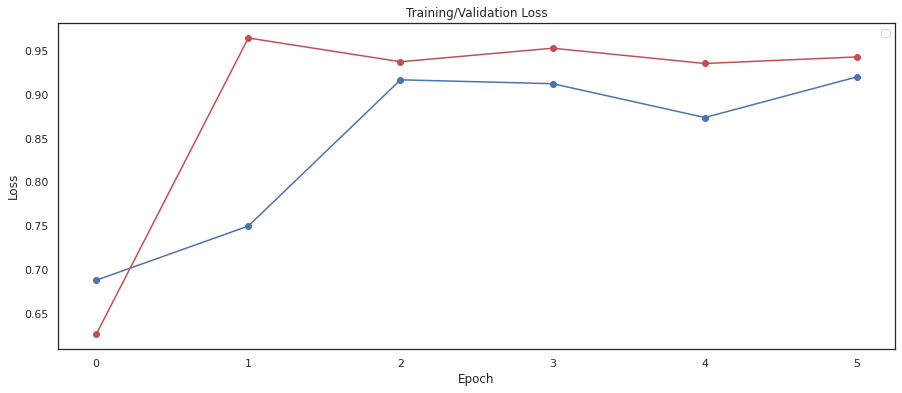

[2020-07-08 22:07:05,775][INFO] ## epoch: best, acc: 0.78048780, f1: 0.67245883, best_f1: 0.67245883



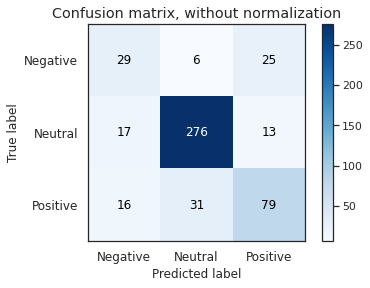

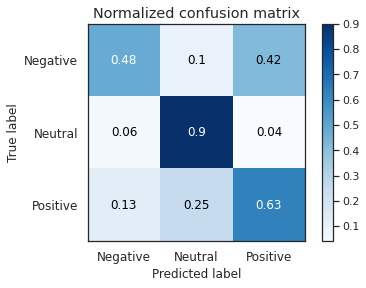

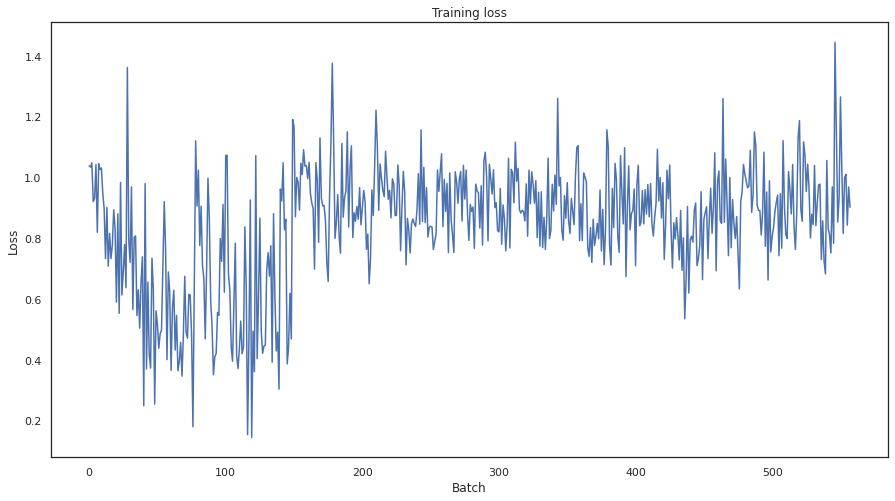

[2020-07-08 22:07:06,590][INFO] ## ================     fold 6        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-08 22:07:31,241][INFO] ## epoch: 1, train loss: 0.75017014, valid loss: 0.76787849, acc: 0.73577, f1: 0.496617, best_f1: 0.49662
, last lr: 0.000098
[2020-07-08 22:07:31,289][INFO] ## ================     epoch 2        ===============


[2020-07-08 22:07:52,802][INFO] ## epoch: 2, train loss: 0.61584657, valid loss: 0.55522045, acc: 0.80081, f1: 0.695222, best_f1: 0.69522
, last lr: 0.000091
[2020-07-08 22:07:52,857][INFO] ## ================     epoch 3        ===============


[2020-07-08 22:08:12,629][INFO] ## epoch: 3, train loss: 0.51332675, valid loss: 0.90151522, acc: 0.57927, f1: 0.410541, best_f1: 0.69522
, last lr: 0.000084
[2020-07-08 22:08:12,681][INFO] ## ================     epoch 4        ===============


[2020-07-08 22:08:33,521][INFO] ## epoch: 4, train loss: 0.46052452, valid loss: 0.48181579, acc: 0.86179, f1: 0.799736, best_f1: 0.79974
, last lr: 0.000077
[2020-07-08 22:08:33,573][INFO] ## ================     epoch 5        ===============


[2020-07-08 22:08:54,843][INFO] ## epoch: 5, train loss: 0.43401227, valid loss: 0.41410021, acc: 0.88008, f1: 0.837921, best_f1: 0.83792
, last lr: 0.000070
[2020-07-08 22:08:54,894][INFO] ## ================     epoch 6        ===============


[2020-07-08 22:09:16,269][INFO] ## epoch: 6, train loss: 0.36610070, valid loss: 0.45543986, acc: 0.88618, f1: 0.841768, best_f1: 0.84177
, last lr: 0.000063
[2020-07-08 22:09:16,320][INFO] ## ================     epoch 7        ===============


[2020-07-08 22:09:35,979][INFO] ## epoch: 7, train loss: 0.31109274, valid loss: 0.39410149, acc: 0.88008, f1: 0.835342, best_f1: 0.84177
, last lr: 0.000056
[2020-07-08 22:09:36,030][INFO] ## ================     epoch 8        ===============


[2020-07-08 22:09:56,789][INFO] ## epoch: 8, train loss: 0.28310243, valid loss: 0.40780084, acc: 0.89431, f1: 0.852460, best_f1: 0.85246
, last lr: 0.000049
[2020-07-08 22:09:56,840][INFO] ## ================     epoch 9        ===============


[2020-07-08 22:10:18,224][INFO] ## epoch: 9, train loss: 0.21875511, valid loss: 0.40714109, acc: 0.89837, f1: 0.858884, best_f1: 0.85888
, last lr: 0.000042
[2020-07-08 22:10:18,279][INFO] ## ================     epoch 10        ===============


[2020-07-08 22:10:37,638][INFO] ## epoch: 10, train loss: 0.18108740, valid loss: 0.39783427, acc: 0.89431, f1: 0.855048, best_f1: 0.85888
, last lr: 0.000035
[2020-07-08 22:10:37,690][INFO] ## ================     epoch 11        ===============


[2020-07-08 22:10:56,551][INFO] ## epoch: 11, train loss: 0.16121867, valid loss: 0.39913322, acc: 0.89024, f1: 0.849790, best_f1: 0.85888
, last lr: 0.000028
[2020-07-08 22:10:56,600][INFO] ## ================     epoch 12        ===============


[2020-07-08 22:11:15,570][INFO] ## epoch: 12, train loss: 0.12861080, valid loss: 0.41916854, acc: 0.89228, f1: 0.856747, best_f1: 0.85888
, last lr: 0.000021
[2020-07-08 22:11:15,620][INFO] ## ================     epoch 13        ===============


[2020-07-08 22:11:36,189][INFO] ## epoch: 13, train loss: 0.09872434, valid loss: 0.42808274, acc: 0.89837, f1: 0.859469, best_f1: 0.85947
, last lr: 0.000014
[2020-07-08 22:11:36,256][INFO] ## ================     epoch 14        ===============


[2020-07-08 22:11:57,669][INFO] ## epoch: 14, train loss: 0.09405811, valid loss: 0.42045147, acc: 0.90244, f1: 0.862281, best_f1: 0.86228
, last lr: 0.000007
[2020-07-08 22:11:57,722][INFO] ## ================     epoch 15        ===============


[2020-07-08 22:12:17,114][INFO] ## epoch: 15, train loss: 0.07712256, valid loss: 0.41072118, acc: 0.89634, f1: 0.855528, best_f1: 0.86228
, last lr: 0.000000
No handles with labels found to put in legend.


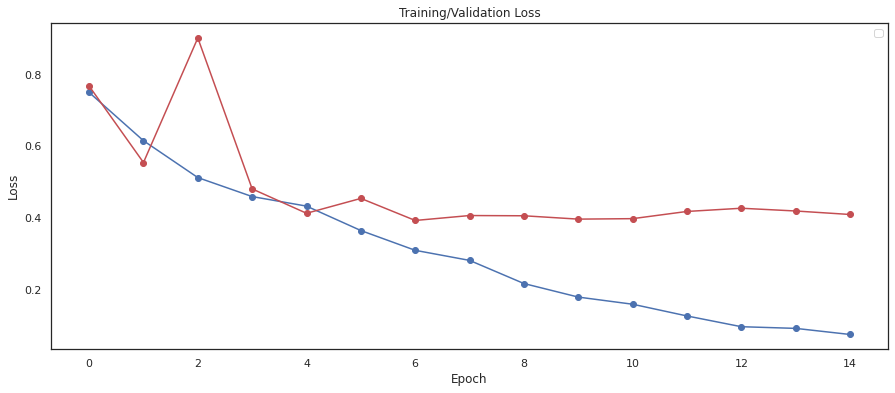

[2020-07-08 22:12:18,999][INFO] ## epoch: best, acc: 0.90243902, f1: 0.86228076, best_f1: 0.86228076



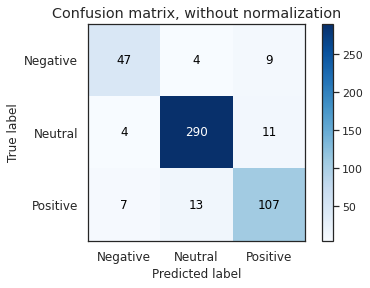

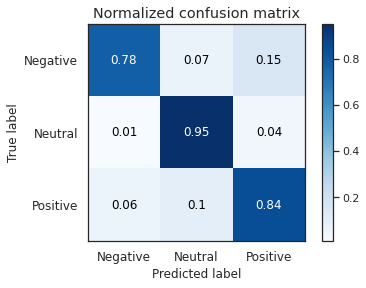

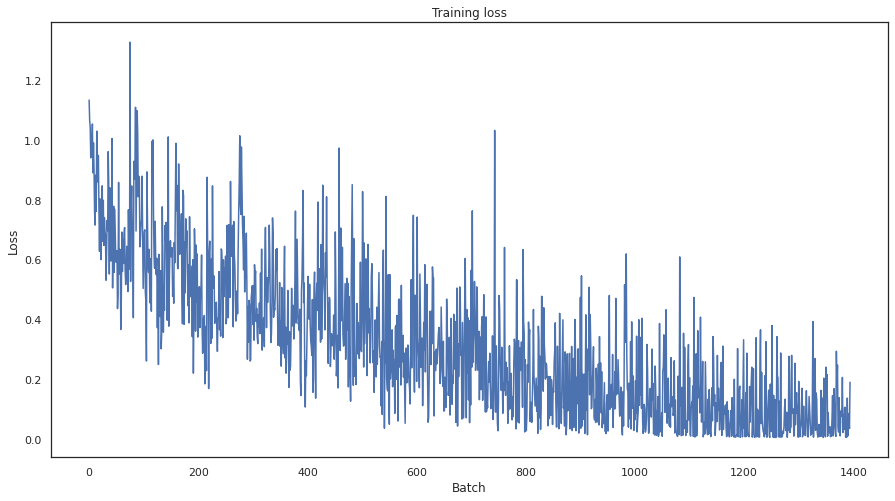

In [30]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    train_bert(fold, train_indices, valid_indices)
    # Number of folds to iterrate
    if fold == 10:
        break


In [31]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))

train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

[2020-07-08 22:12:21,132][INFO] ## 0.7640090085594217


sentence  ...  pred_target_raise
0  According to Gran , the company has no plans t...  ...           0.000740
1  With the new production plant the company woul...  ...           0.974128
2  For the last quarter of 2010 , Componenta 's n...  ...           0.981188
3  In the third quarter of 2010 , net sales incre...  ...           0.742036
4  Operating profit rose to EUR 13.1 mn from EUR ...  ...           0.768192

[5 rows x 6 columns]

# Save Data

In [33]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [34]:
# Save text data
save_data(train_df, 'train_df')
save_data(train_df, 'train_tone_df')